In [1]:
import argparse
import os
import random

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# dataframes
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# from PIL import Image
# import matplotlib.animation as animation
# from IPython.display import HTML

# signal processing
from scipy import signal
import pywt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [2]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 32

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [5]:
gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')
gw_parameters_df = pd.read_csv('../data/gw-raw-data/richers_1764_parameters.csv')

gw_parameters_df = gw_parameters_df.transpose()

# y-axis processing
distance = 3.086e22
gw_df = gw_df / distance

gw_mean = gw_df.mean().mean()
print('Dataset mean: ',  gw_mean)

gw_std = gw_df.std().std()
print('Dataset std: ',  gw_std)

Dataset mean:  -1.5632674697219778e-24
Dataset std:  4.1450662997306195e-22


torch.Size([32, 1, 512])


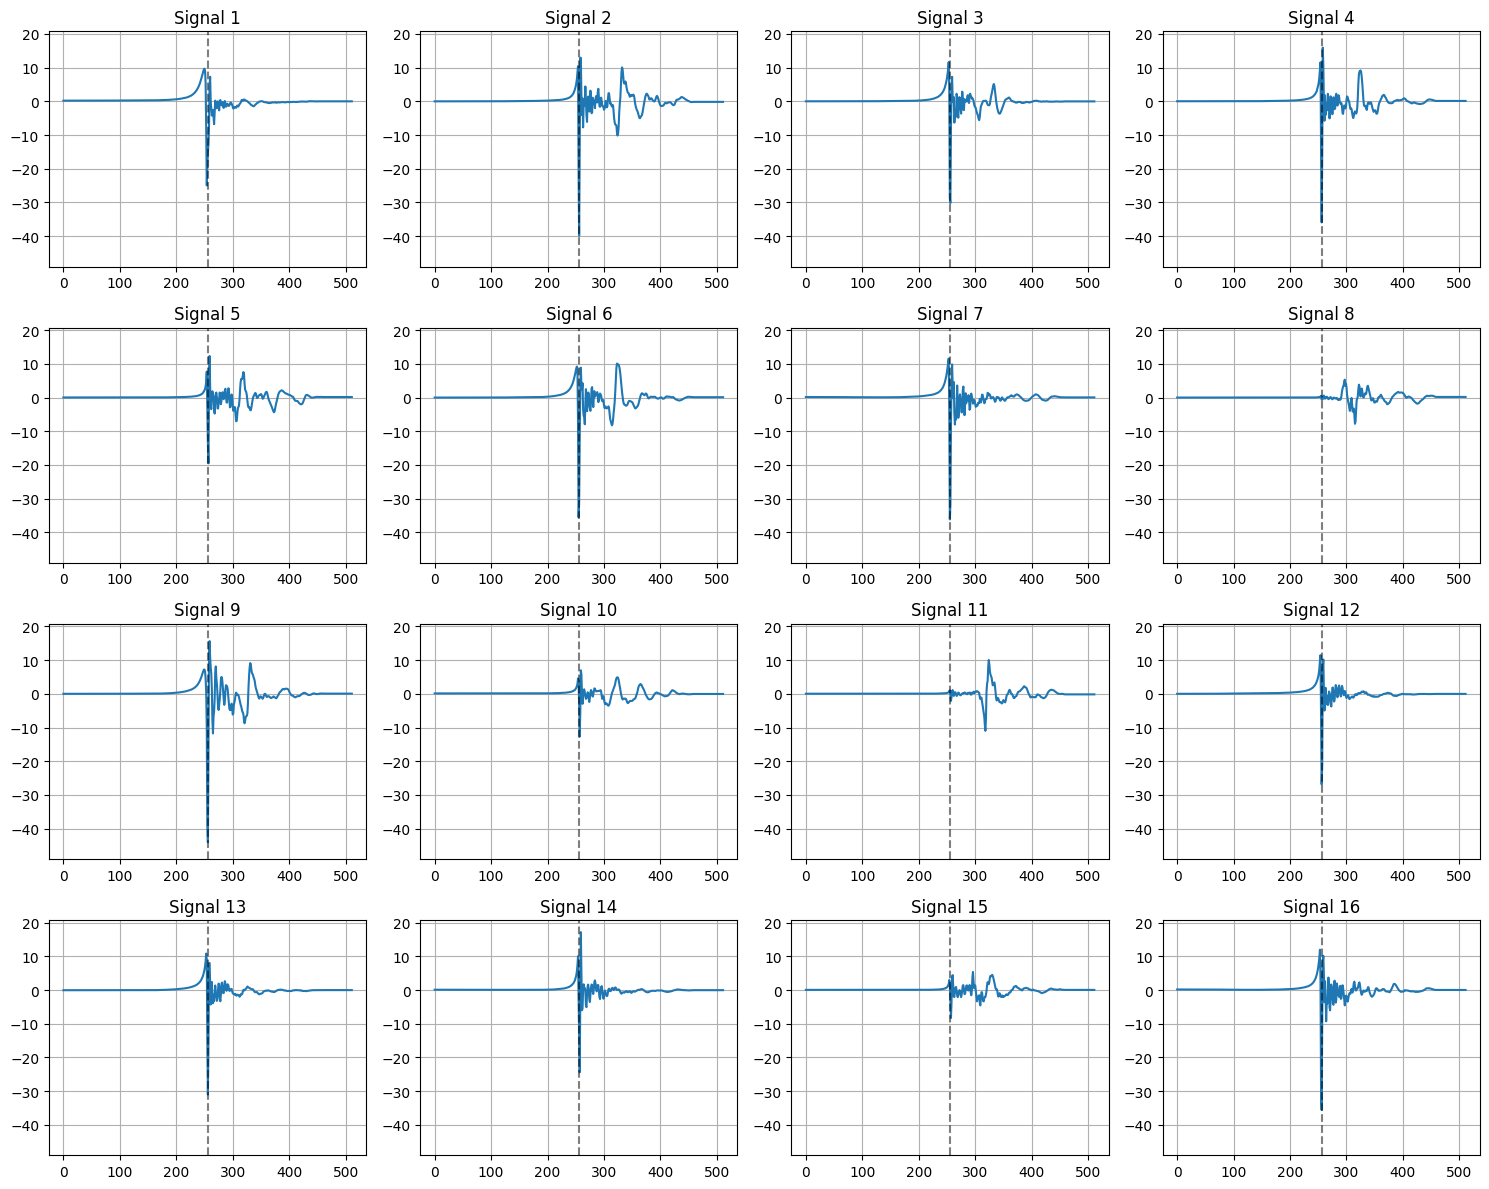

In [557]:
def normalize_to_minus_one_one(data):
        min_val = np.min(data)
        max_val = np.max(data)
        normalized_data = -1 + 2 * (data - min_val) / (max_val - min_val)
        return normalized_data

def standardize(dataset):
        standardized_dataset = (dataset - gw_mean) / gw_std
        return standardized_dataset

class GWDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file).astype('float32')

    def __len__(self):
        return len(self.data.columns)

    def __getitem__(self, idx):
        signal = self.data.iloc[:, idx].values
        signal = signal.reshape(1, -1)

        # process signal from strain * distance (10 kpc) -> just strain
        distance = 3.086e22
        signal = signal / distance

        # reshape signal to have first 512 - 407 values to be 0.
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = standardize(signal_padded)

        return signal_standardized

dataset = GWDataset("../data/gw-raw-data/richers_1764.csv")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_batch = next(iter(dataloader))

# Expecting: (32, 1, 512)
print(real_batch.shape)

common_ylim = (real_batch[:,:,:].min(), real_batch[:,:,:].max())

def plot_and_save_waveforms(real_batch, filename='waveforms.png'):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_batch.size(dim=2))
        y = real_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)
    
    for i in range(512, 8*4):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)  # Save the plot to a PNG file
    
    plt.show()

# Example usage: Display and save the plot to 'waveforms.png'
plot_and_save_waveforms(real_batch, filename='../data/gw-dcgans-plots/real_data.png')

### Weight Initialisation (Random Noise)

In [558]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [559]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(ngf * 64),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 32),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 16),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.Tanh()
        )

    def forward(self, x):
        # print(x.shape)
        x = self.main(x)
        return x

In [560]:
# # Create the generator
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 4096, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(4096, 2048, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), b

### Discriminator

In [561]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                # xl kernel, stride and padding on this one (first layer group)
                nn.Conv1d(nc, ndf, kernel_size=8, stride=4, padding=2, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                # xl kernel, stride and padding on this one (last layer group)
                nn.Conv1d(ndf * 32, nc, kernel_size=8,
                        stride=4, padding=2, bias=False),
            )

            # fully conencted layer to output probability
            self.fc = nn.Sequential(
                nn.Dropout(0.25),
                nn.Sigmoid()
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            # print(x)
            return x

elif (gans_type == "wgans"):
    class Critic(nn.Module):
        def __init__(self):
            super(Critic, self).__init__()
            self.main = nn.Sequential(
                # xl kernel, stride and padding on this one (first layer group)
                nn.Conv1d(nc, ndf, kernel_size=8, stride=4, padding=2, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                # xl kernel, stride and padding on this one (last layer group)
                nn.Conv1d(ndf * 32, nc, kernel_size=8,
                        stride=4, padding=2, bias=False),
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            # x = self.fc(x)
            # print(x)
            return x

In [562]:
if (gans_type == "dcgans"):
    netD = Discriminator().to(device)
    netD.apply(weights_init)

    print(netD)

    model = Discriminator()
    summary(model, input_size=(1, 512))

elif (gans_type == "wgans"):
    netC = Critic().to(device)
    netC.apply(weights_init)

    print(netC)

    model = Critic()
    summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.25, inp

### Loss functions and Optimisers

In [563]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Starting Training Loop...
[0/32][0/56]	Loss_D: 2.2424	Loss_G: 0.9130	D(x): 0.6103	D(G(z)): 0.5285 / 0.4461
[0/32][50/56]	Loss_D: 1.9285	Loss_G: 8.0261	D(x): 0.1396	D(G(z)): 0.7503 / 0.8592


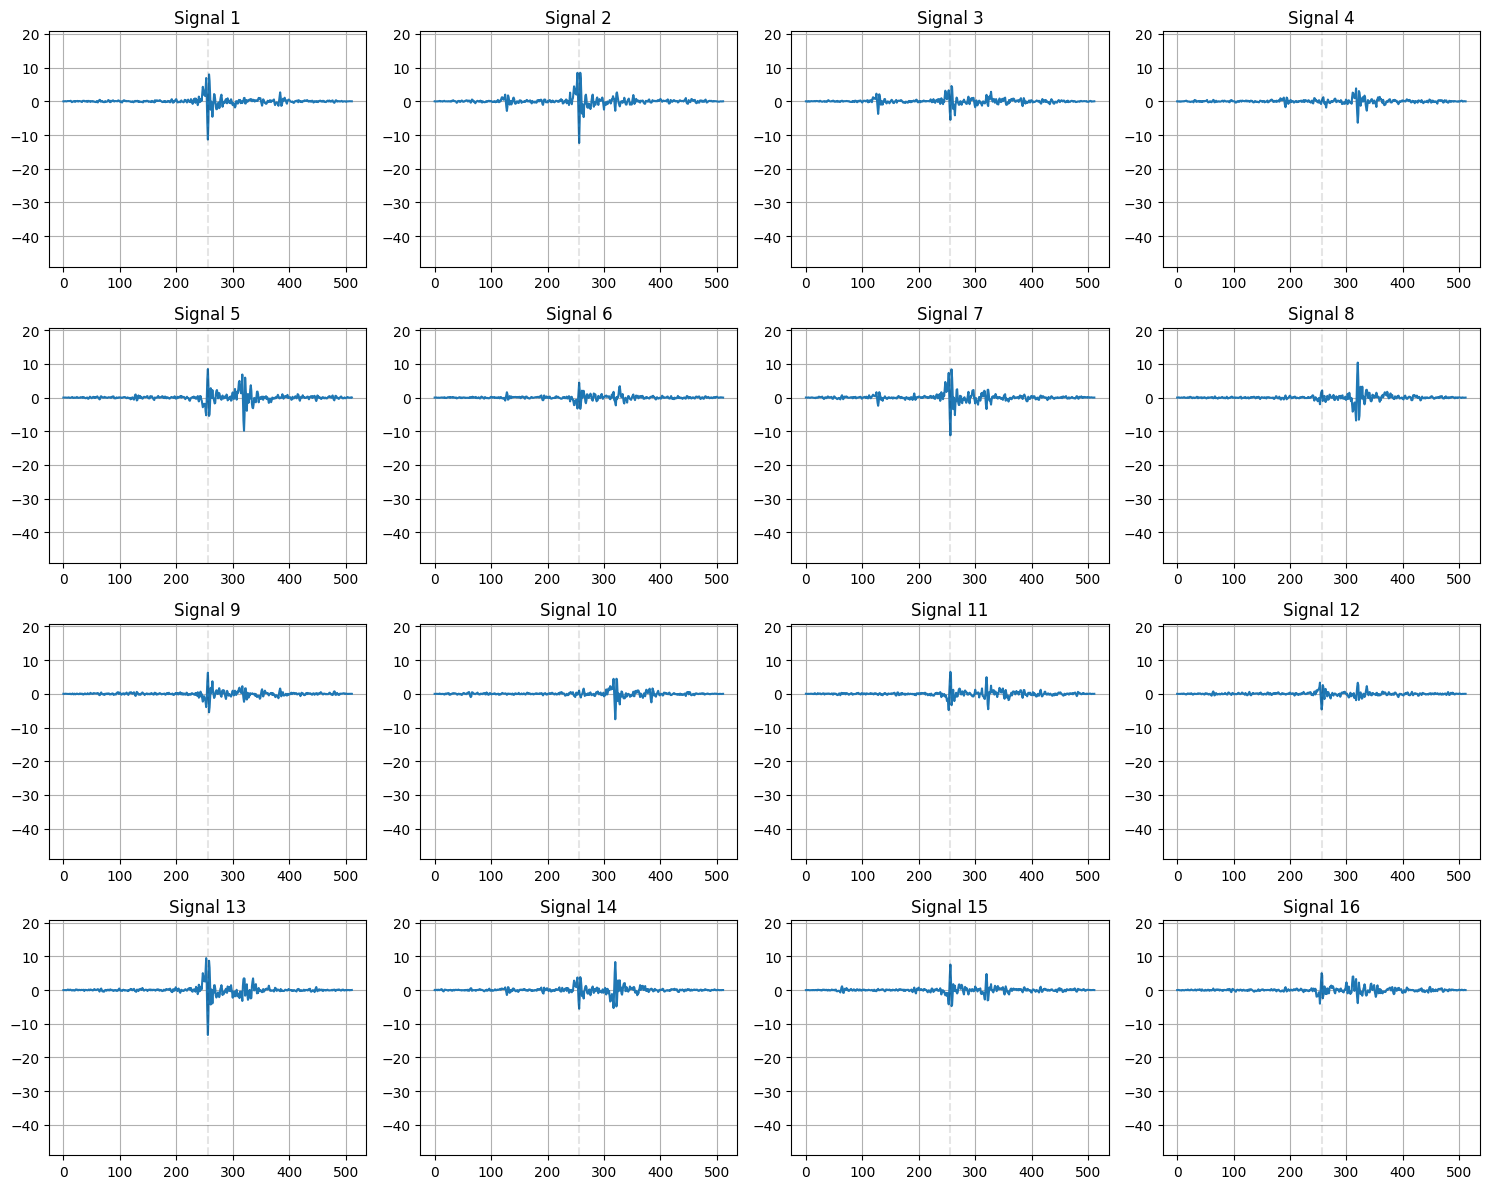

[1/32][0/56]	Loss_D: 2.1240	Loss_G: 7.4731	D(x): 0.0471	D(G(z)): 0.3780 / 0.8356
[1/32][50/56]	Loss_D: 0.7667	Loss_G: 2.7406	D(x): 0.1587	D(G(z)): 0.7959 / 0.7795


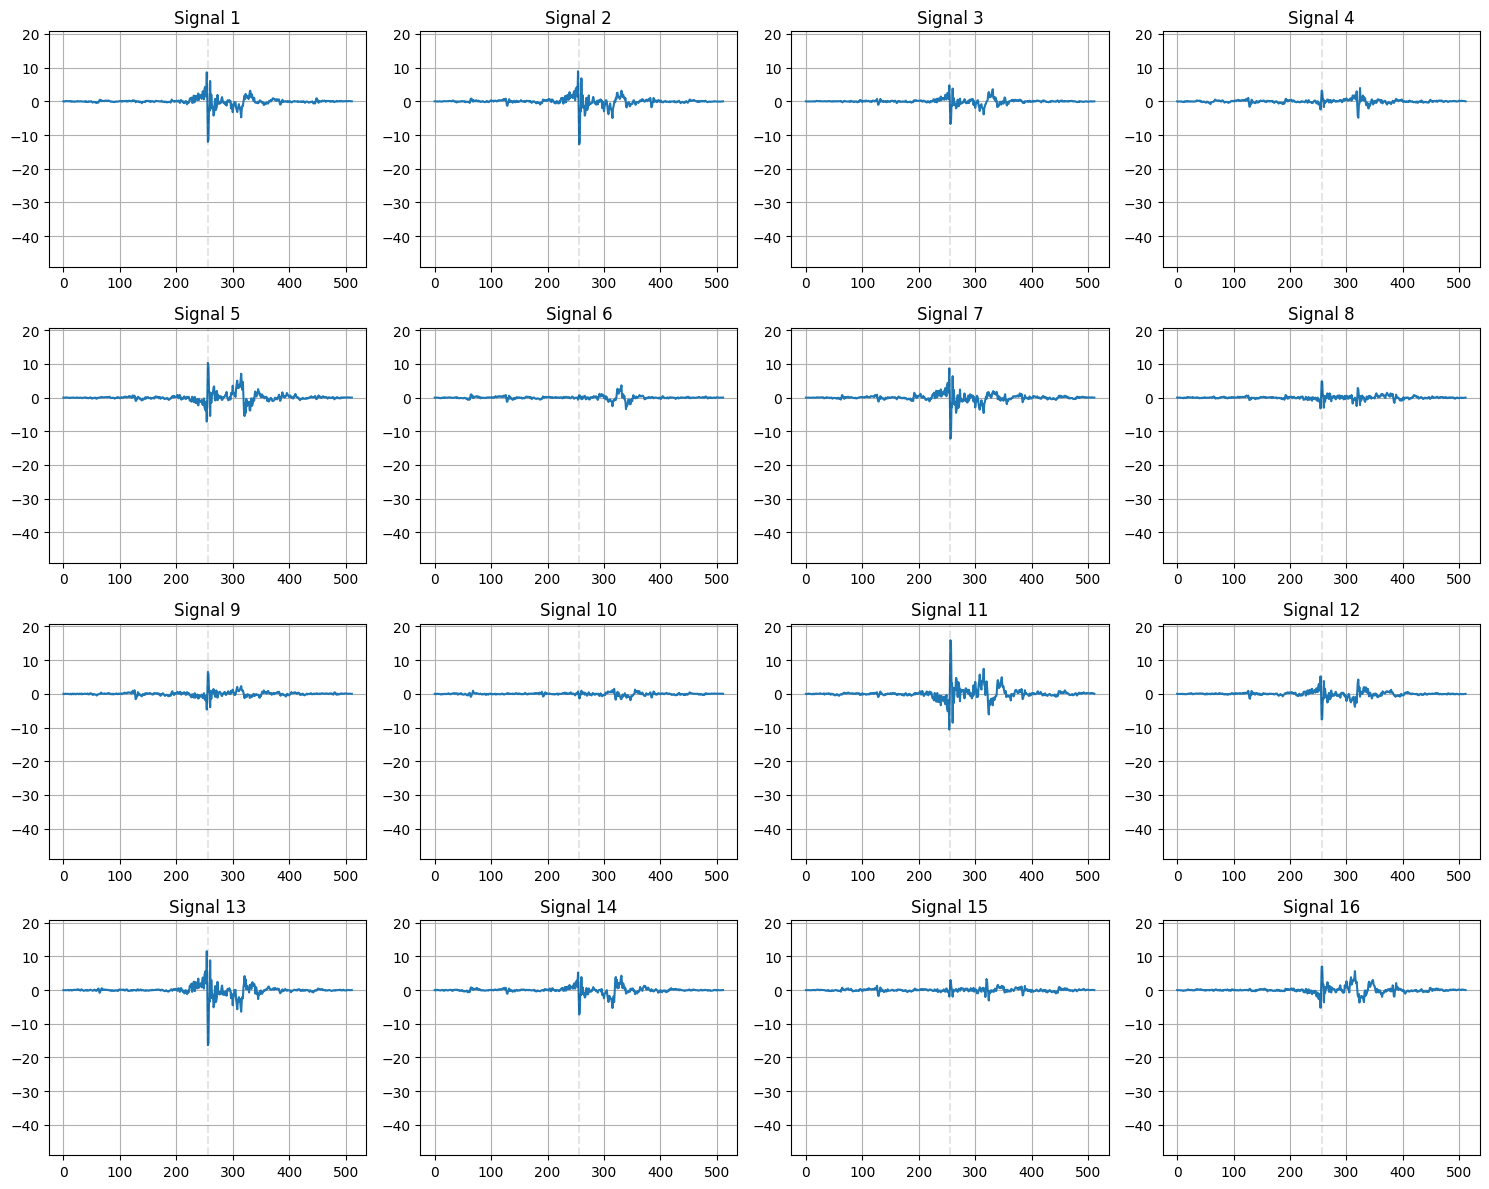

[2/32][0/56]	Loss_D: 1.0088	Loss_G: 2.3077	D(x): 0.1255	D(G(z)): 0.7151 / 0.7590
[2/32][50/56]	Loss_D: 1.0443	Loss_G: 1.9873	D(x): 0.1457	D(G(z)): 0.8137 / 0.6819


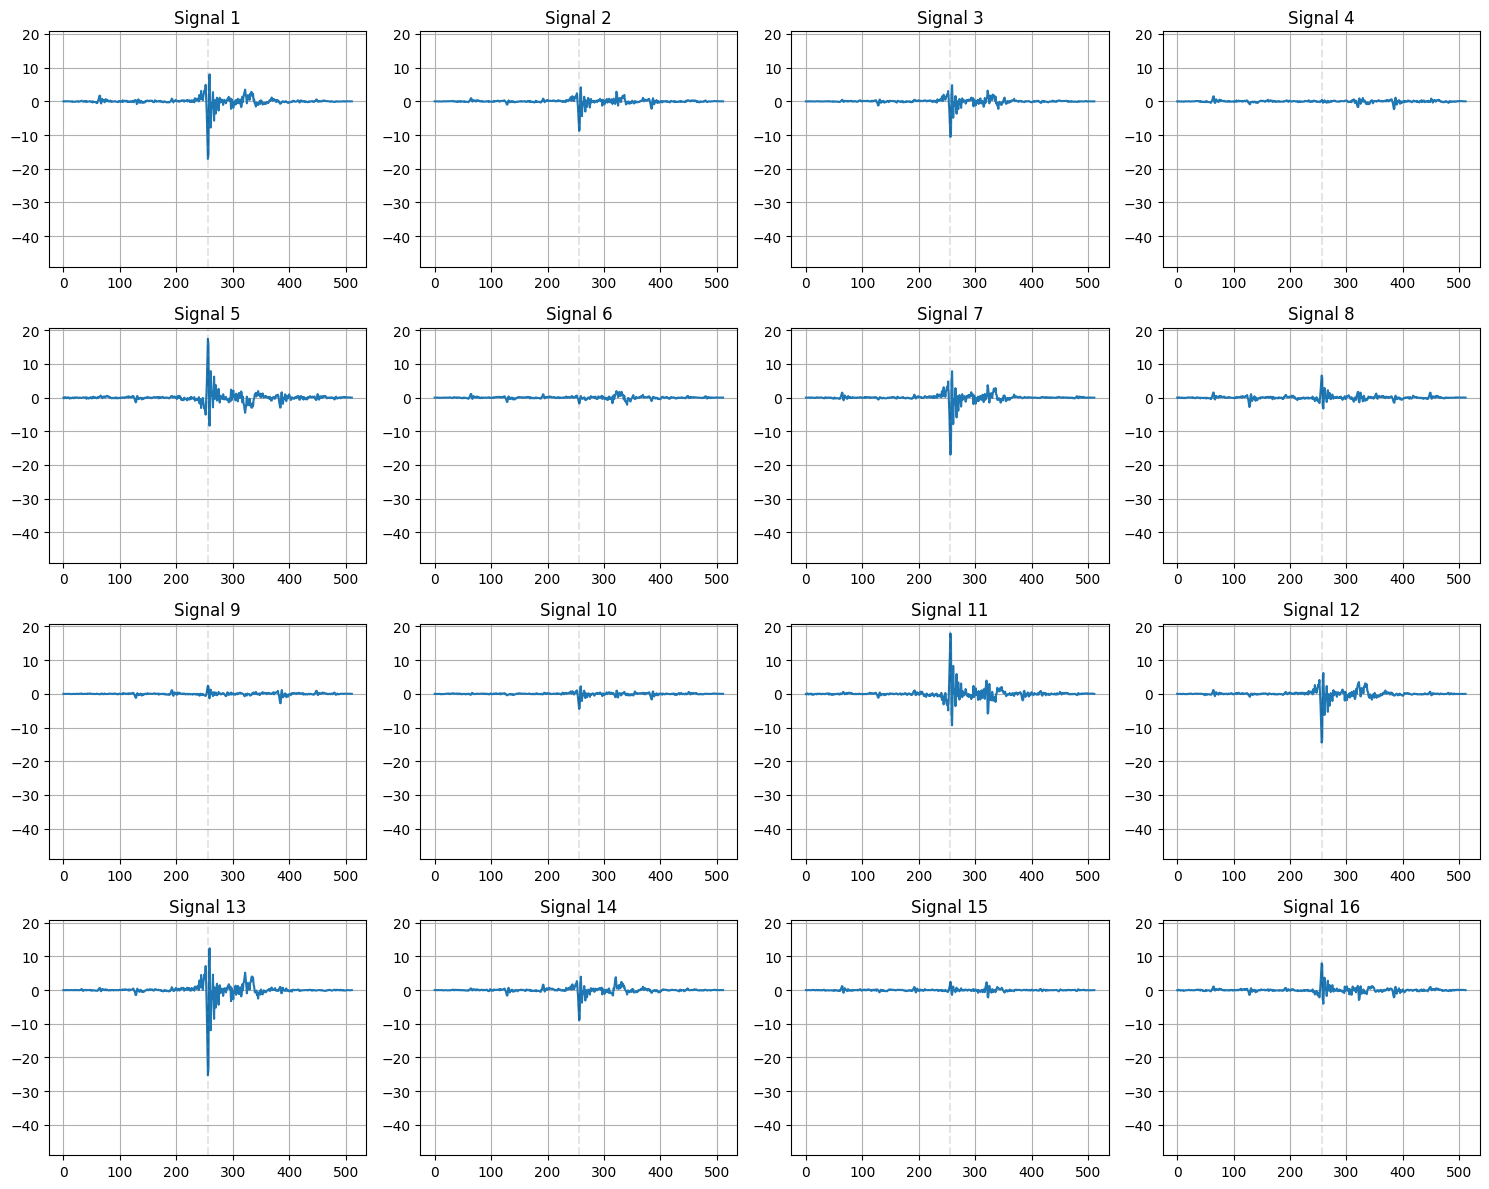

[3/32][0/56]	Loss_D: 1.0053	Loss_G: 3.1873	D(x): 0.0956	D(G(z)): 0.8802 / 0.8325
[3/32][50/56]	Loss_D: 0.6106	Loss_G: 2.4985	D(x): 0.1019	D(G(z)): 0.7080 / 0.7674


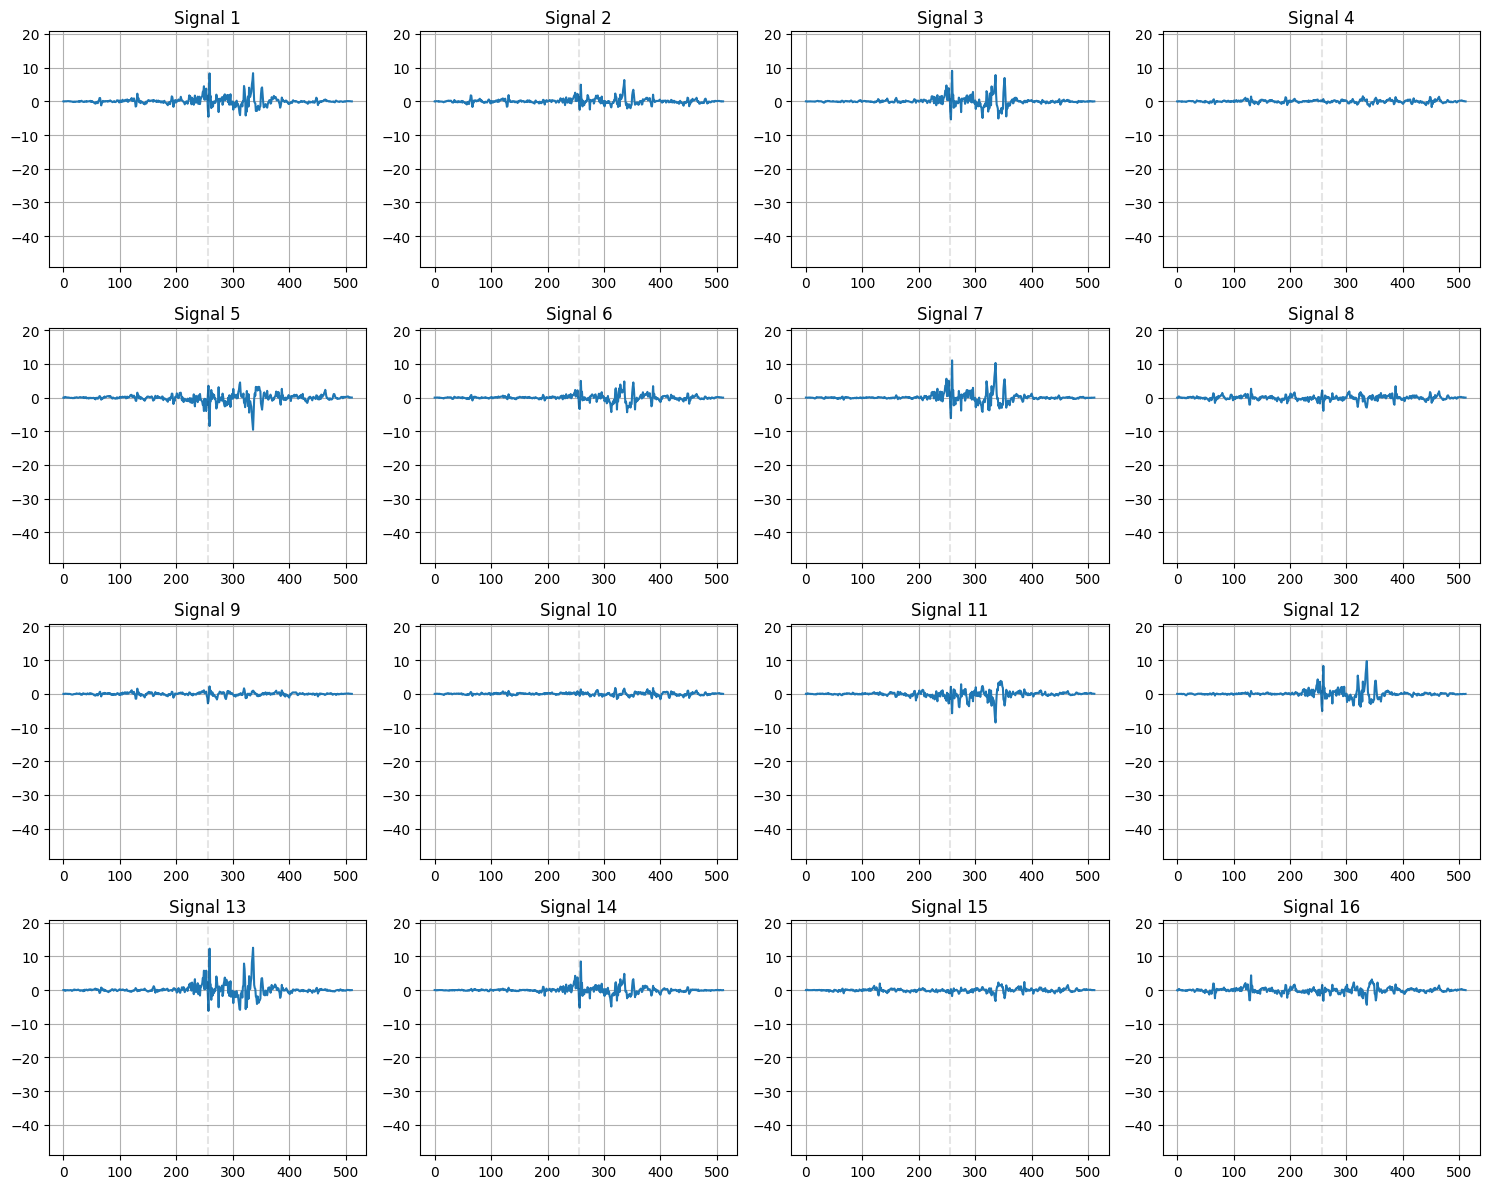

[4/32][0/56]	Loss_D: 0.8274	Loss_G: 2.3730	D(x): 0.1118	D(G(z)): 0.6850 / 0.6754
[4/32][50/56]	Loss_D: 0.5227	Loss_G: 2.2054	D(x): 0.1162	D(G(z)): 0.7912 / 0.7752


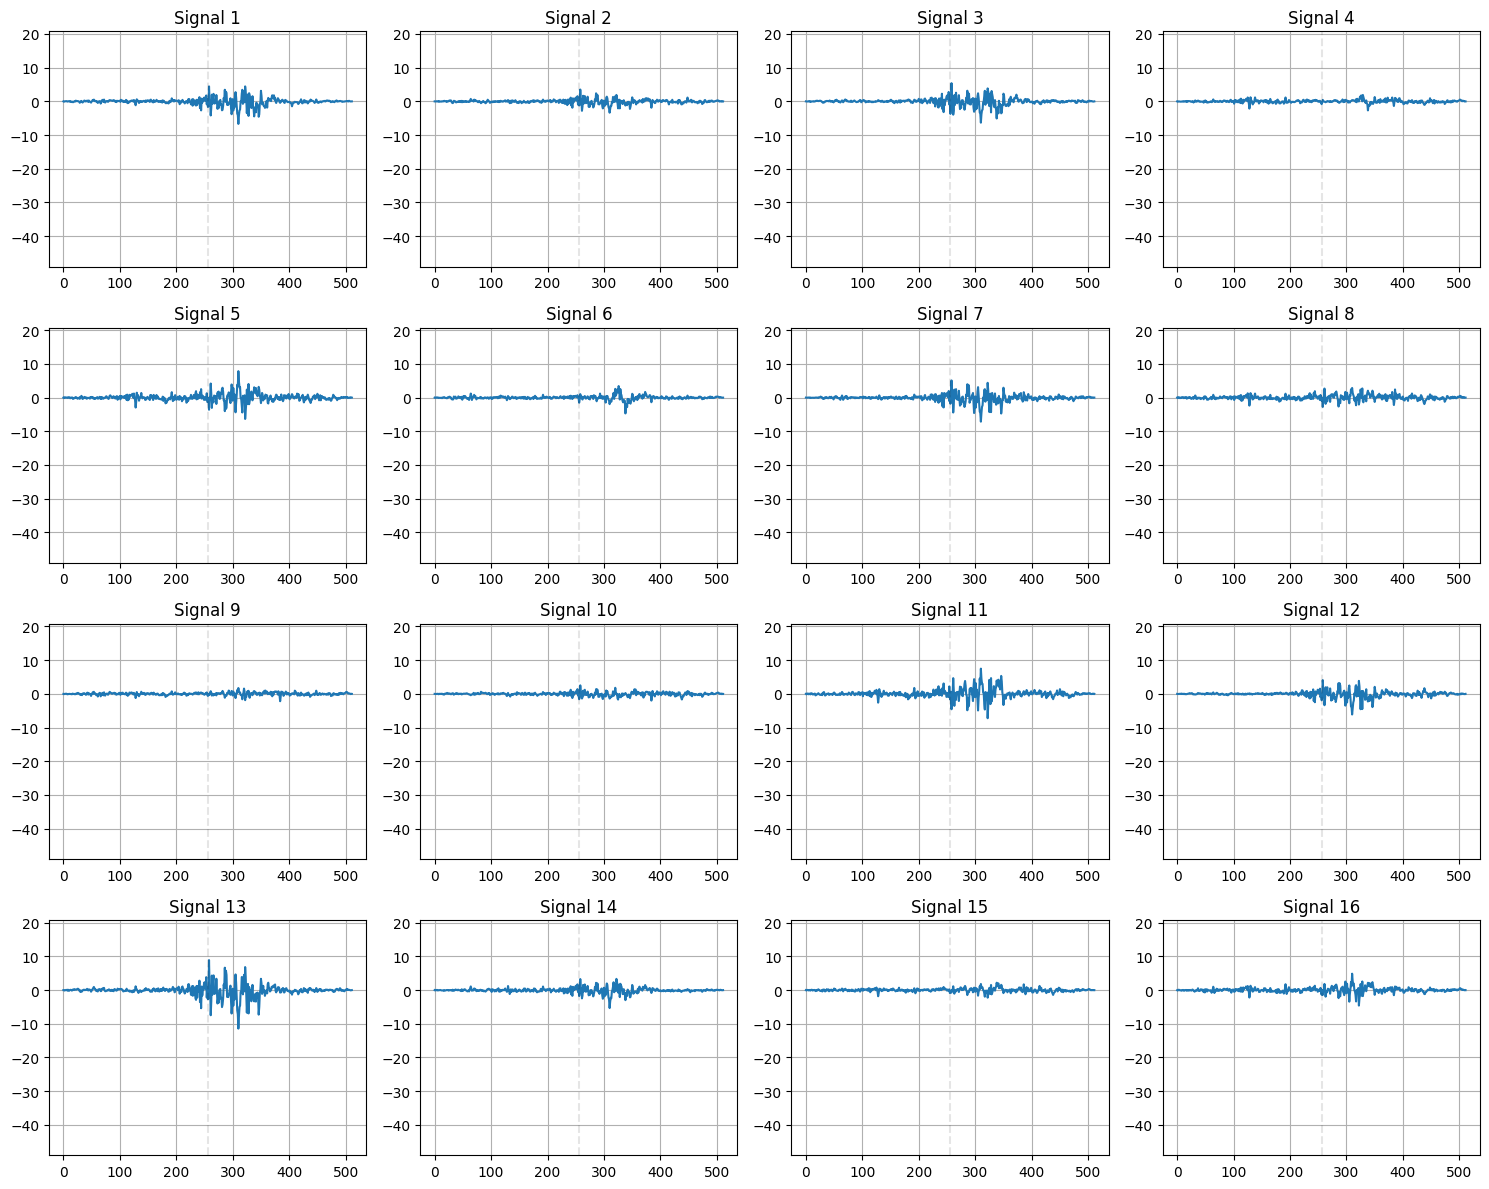

[5/32][0/56]	Loss_D: 1.3944	Loss_G: 3.7853	D(x): 0.1106	D(G(z)): 0.4386 / 0.8061
[5/32][50/56]	Loss_D: 1.0803	Loss_G: 2.2812	D(x): 0.1623	D(G(z)): 0.8087 / 0.7753


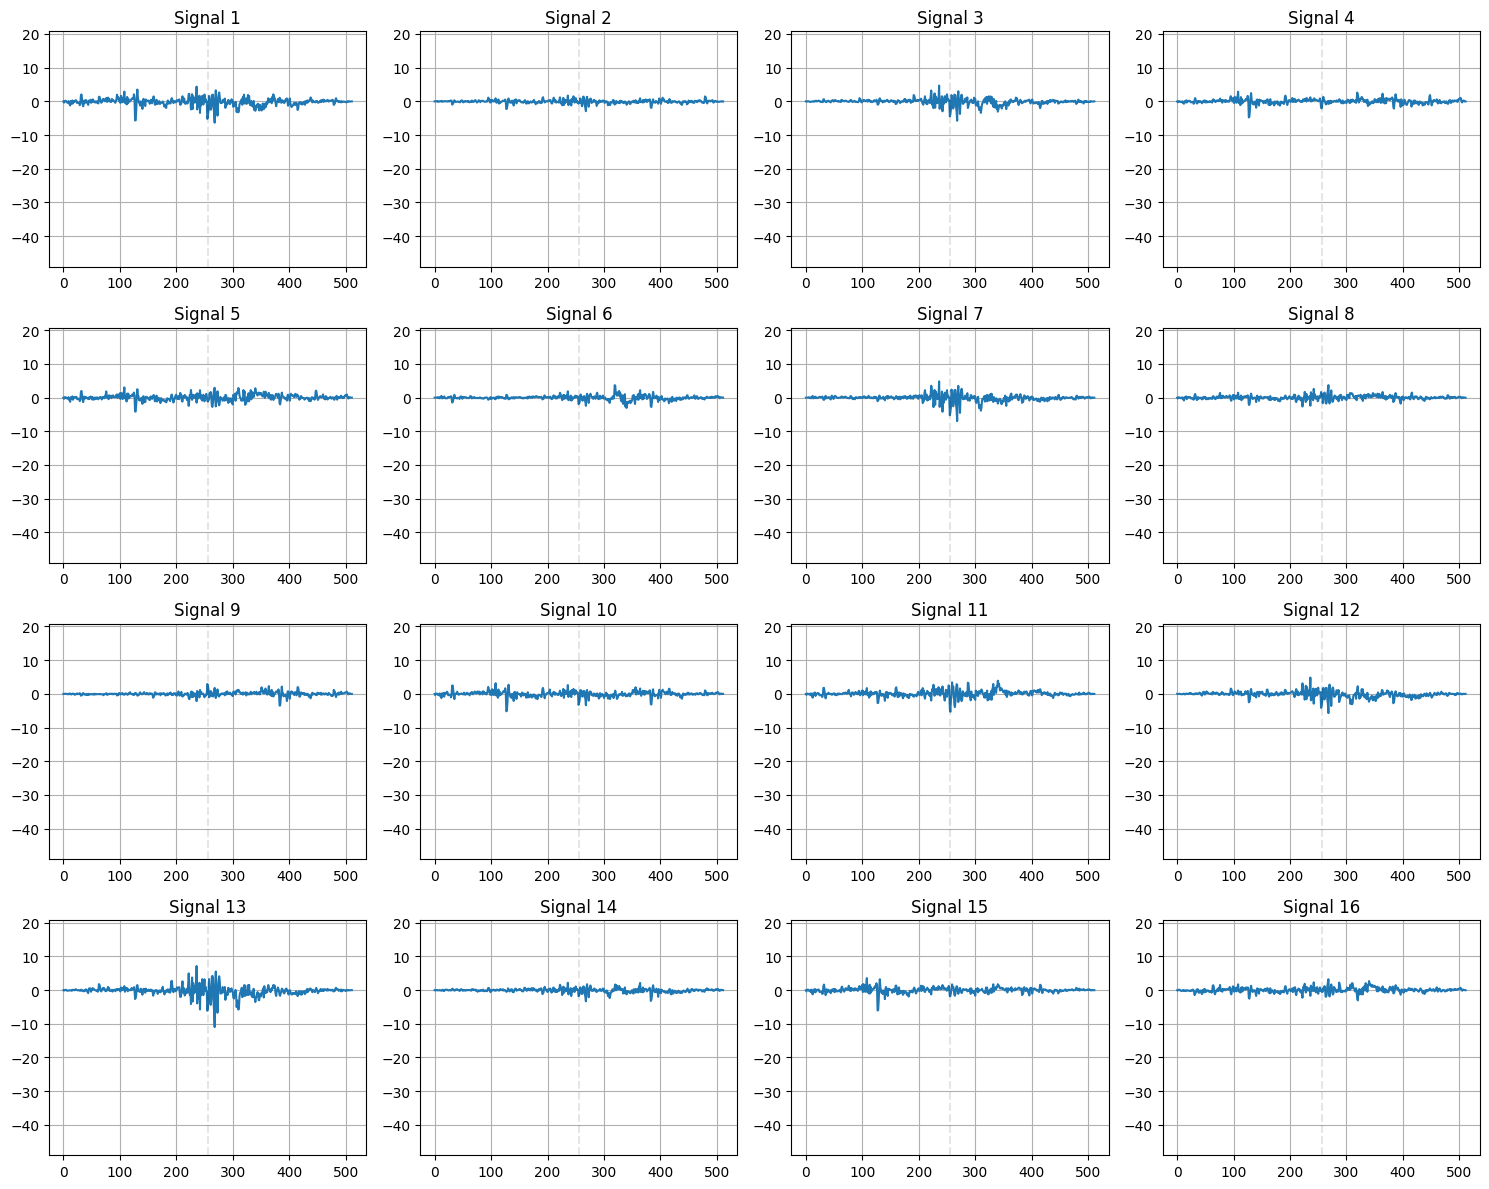

[6/32][0/56]	Loss_D: 1.0496	Loss_G: 3.2900	D(x): 0.2027	D(G(z)): 0.8145 / 0.8194
[6/32][50/56]	Loss_D: 0.5819	Loss_G: 1.7584	D(x): 0.0801	D(G(z)): 0.7664 / 0.6870


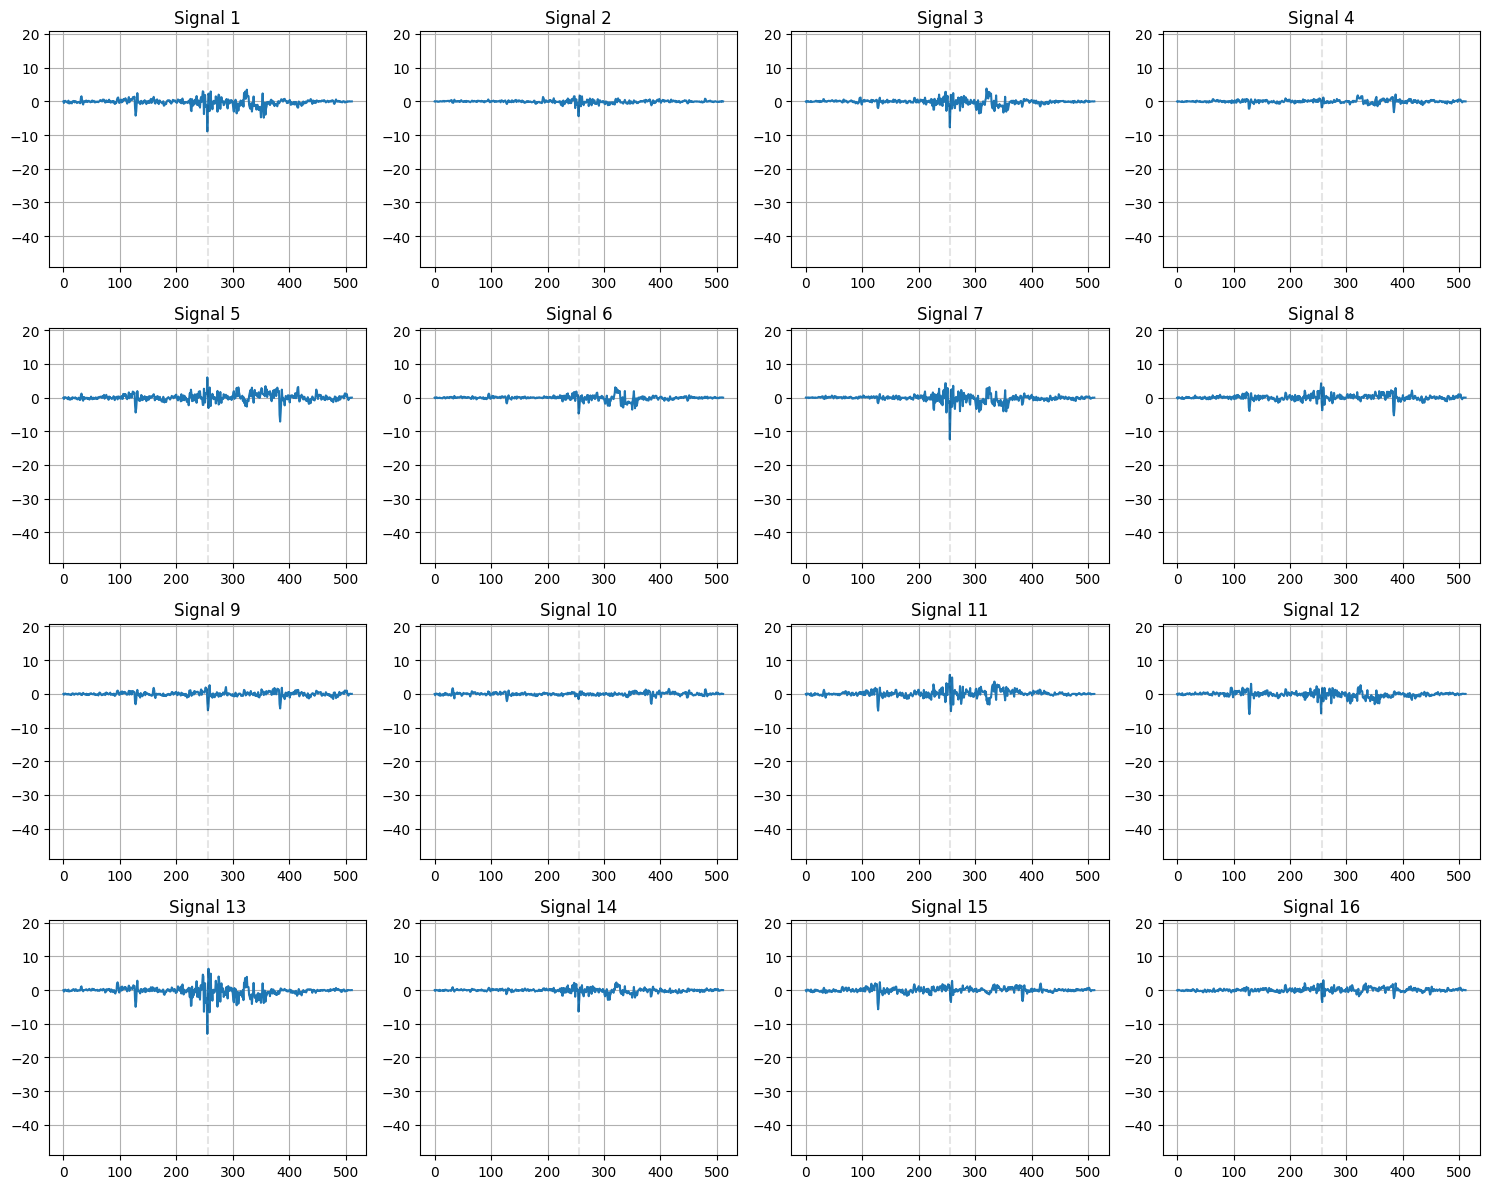

[7/32][0/56]	Loss_D: 0.6295	Loss_G: 1.6357	D(x): 0.1195	D(G(z)): 0.8102 / 0.7065
[7/32][50/56]	Loss_D: 0.8625	Loss_G: 2.5274	D(x): 0.1772	D(G(z)): 0.6684 / 0.8086


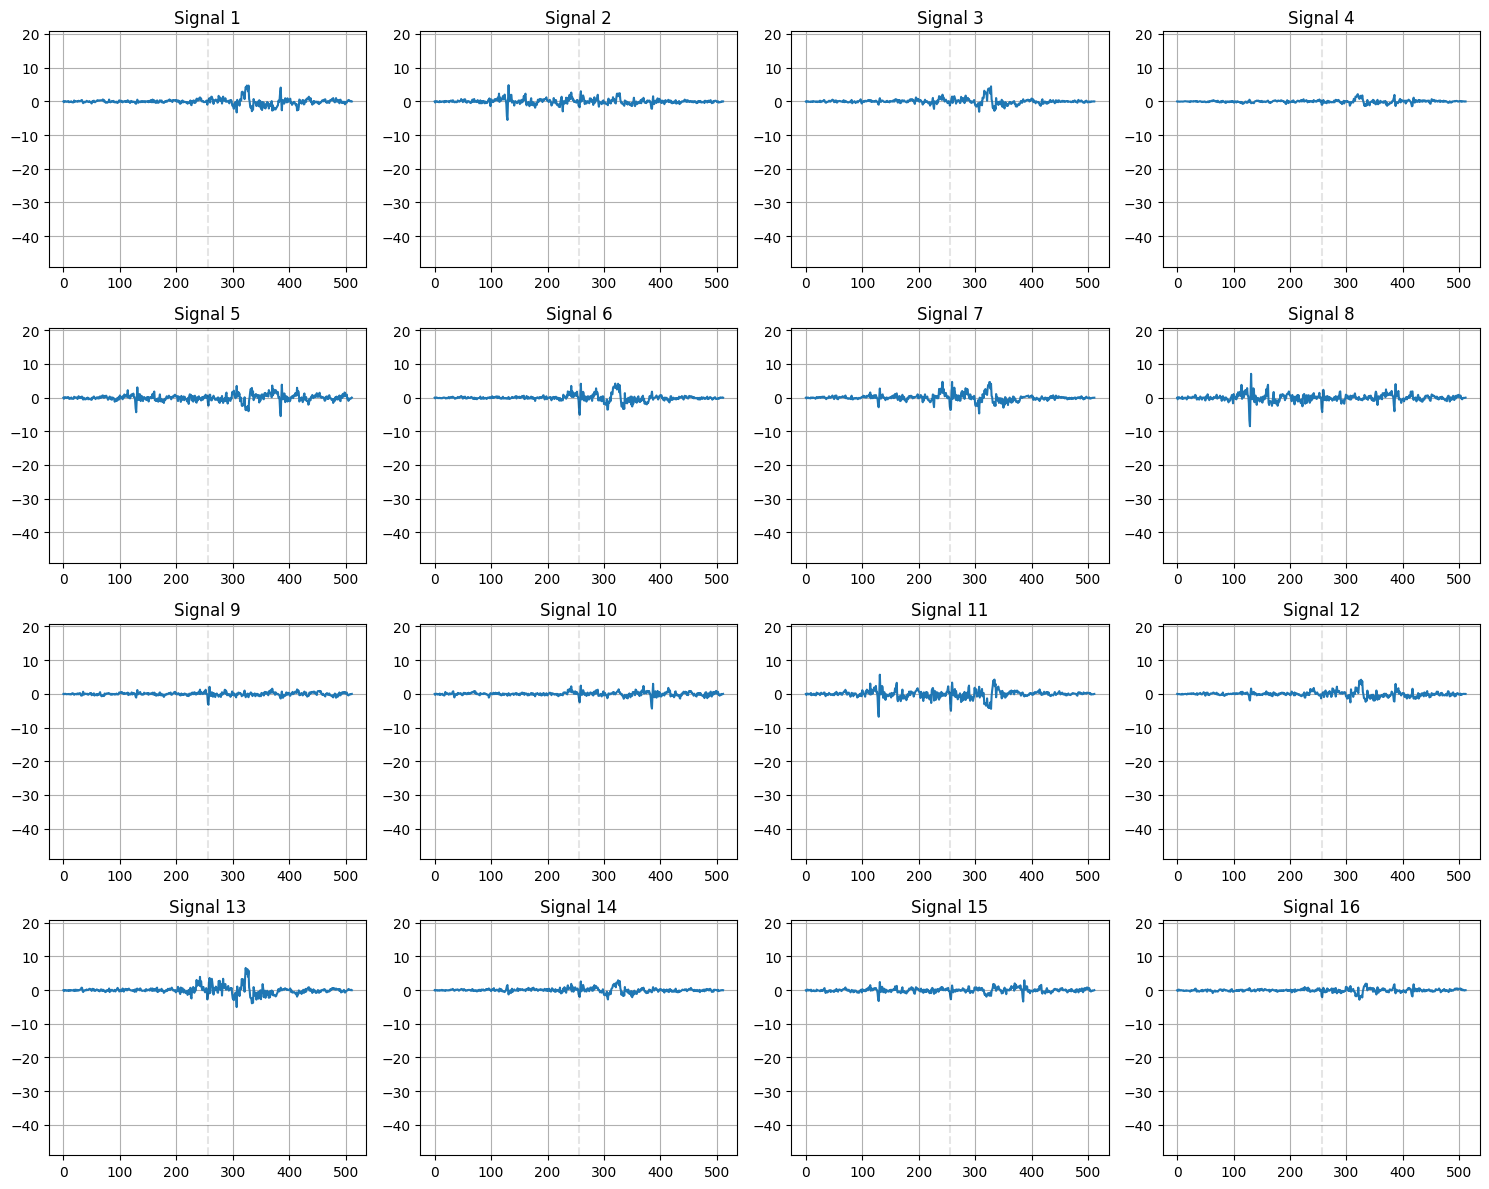

[8/32][0/56]	Loss_D: 0.9357	Loss_G: 2.4610	D(x): 0.1850	D(G(z)): 0.7861 / 0.7280
[8/32][50/56]	Loss_D: 0.9535	Loss_G: 2.6736	D(x): 0.1727	D(G(z)): 0.7596 / 0.8207


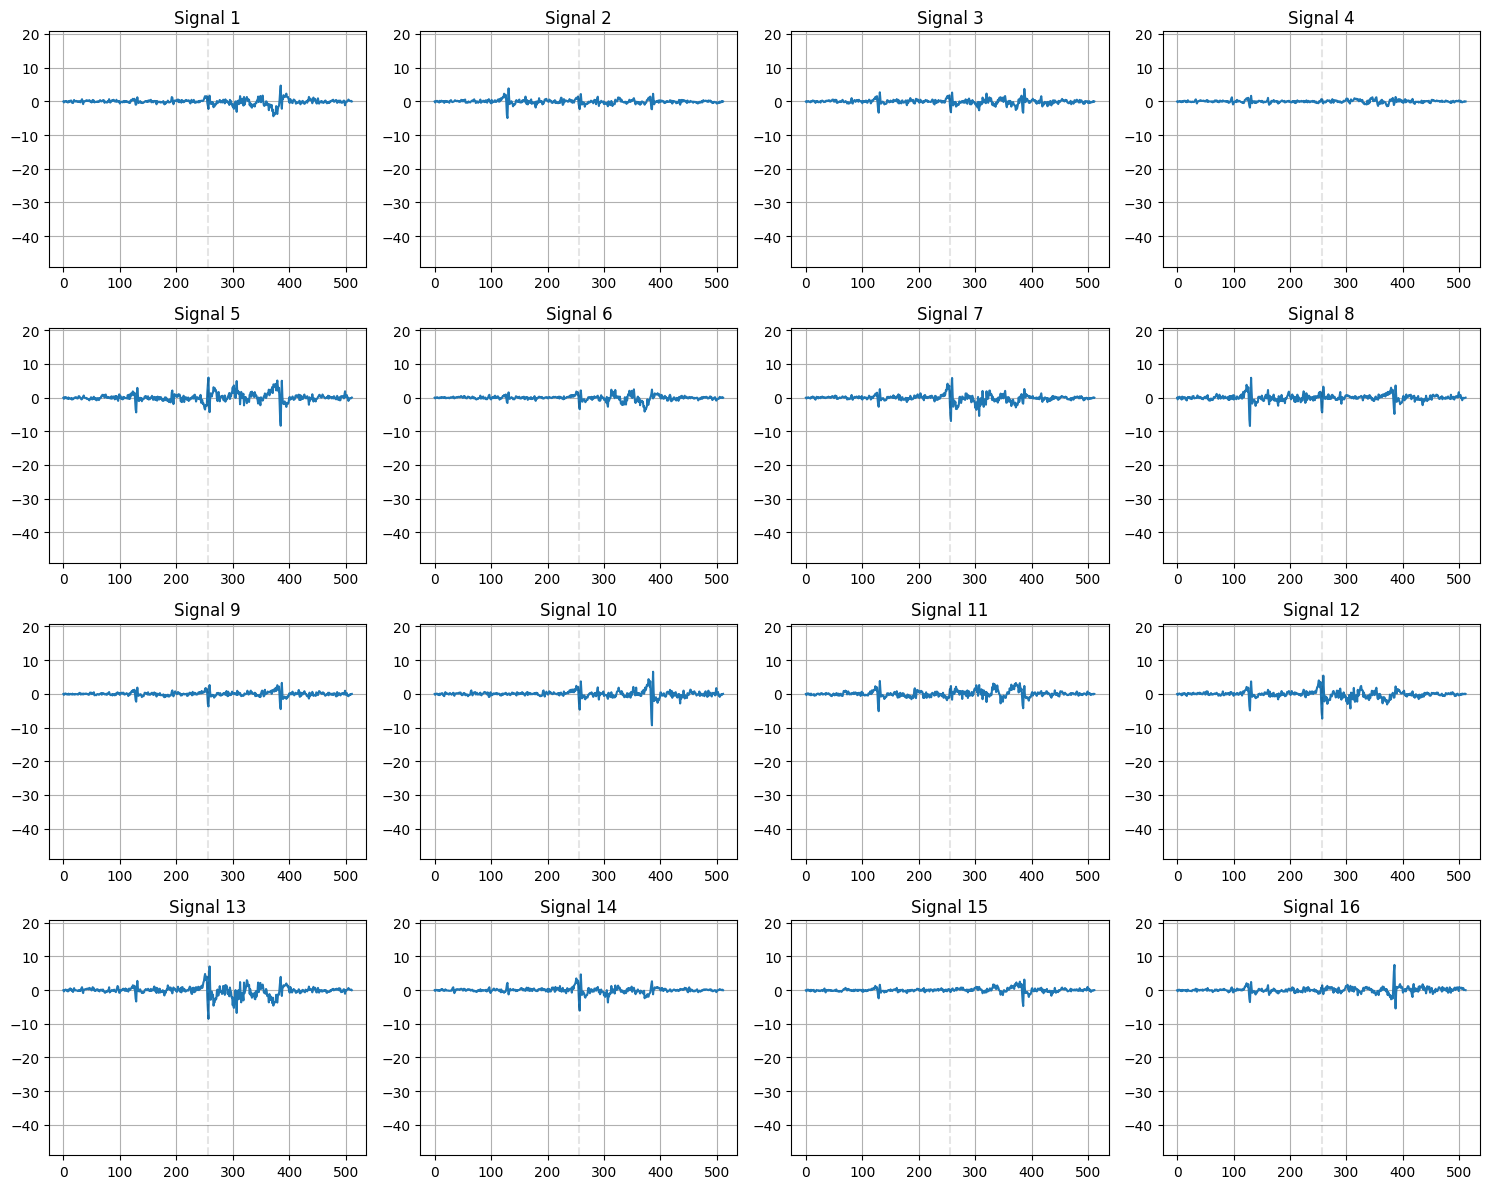

[9/32][0/56]	Loss_D: 0.7813	Loss_G: 3.4920	D(x): 0.1678	D(G(z)): 0.8726 / 0.7613
[9/32][50/56]	Loss_D: 0.9049	Loss_G: 4.4991	D(x): 0.1855	D(G(z)): 0.8431 / 0.8835


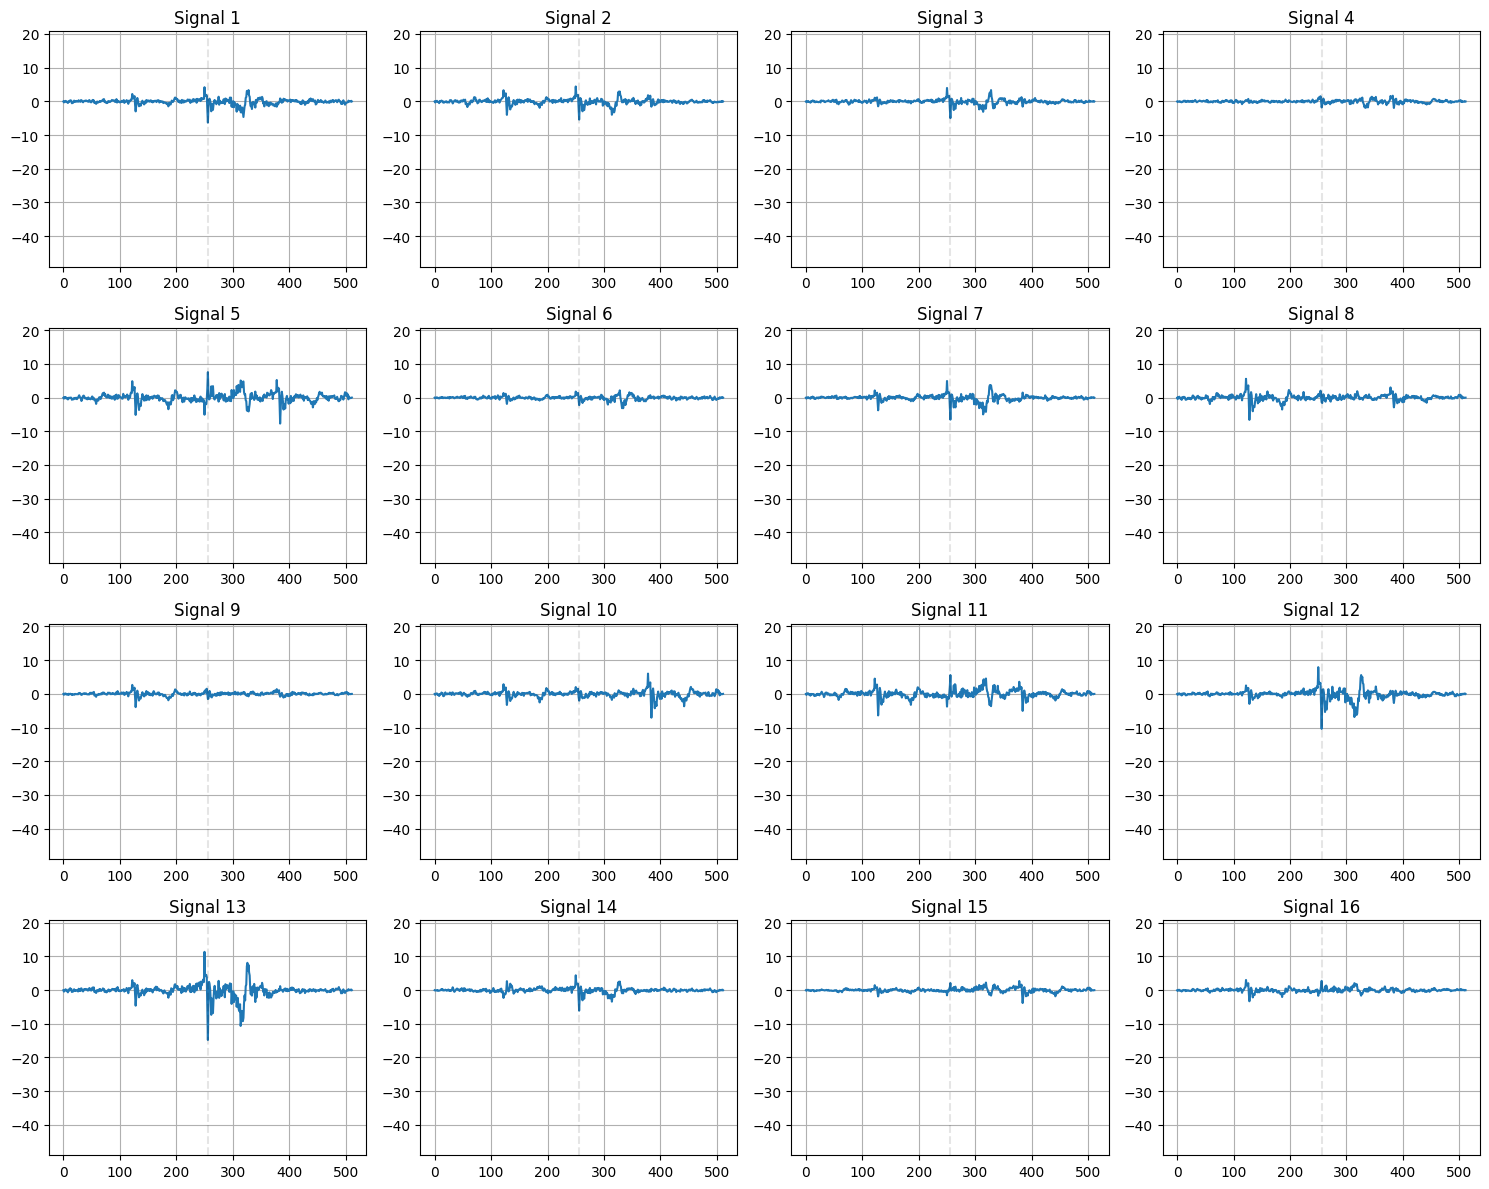

[10/32][0/56]	Loss_D: 0.6644	Loss_G: 2.8398	D(x): 0.0946	D(G(z)): 0.7346 / 0.8216
[10/32][50/56]	Loss_D: 0.8911	Loss_G: 2.9465	D(x): 0.0954	D(G(z)): 0.8311 / 0.8513


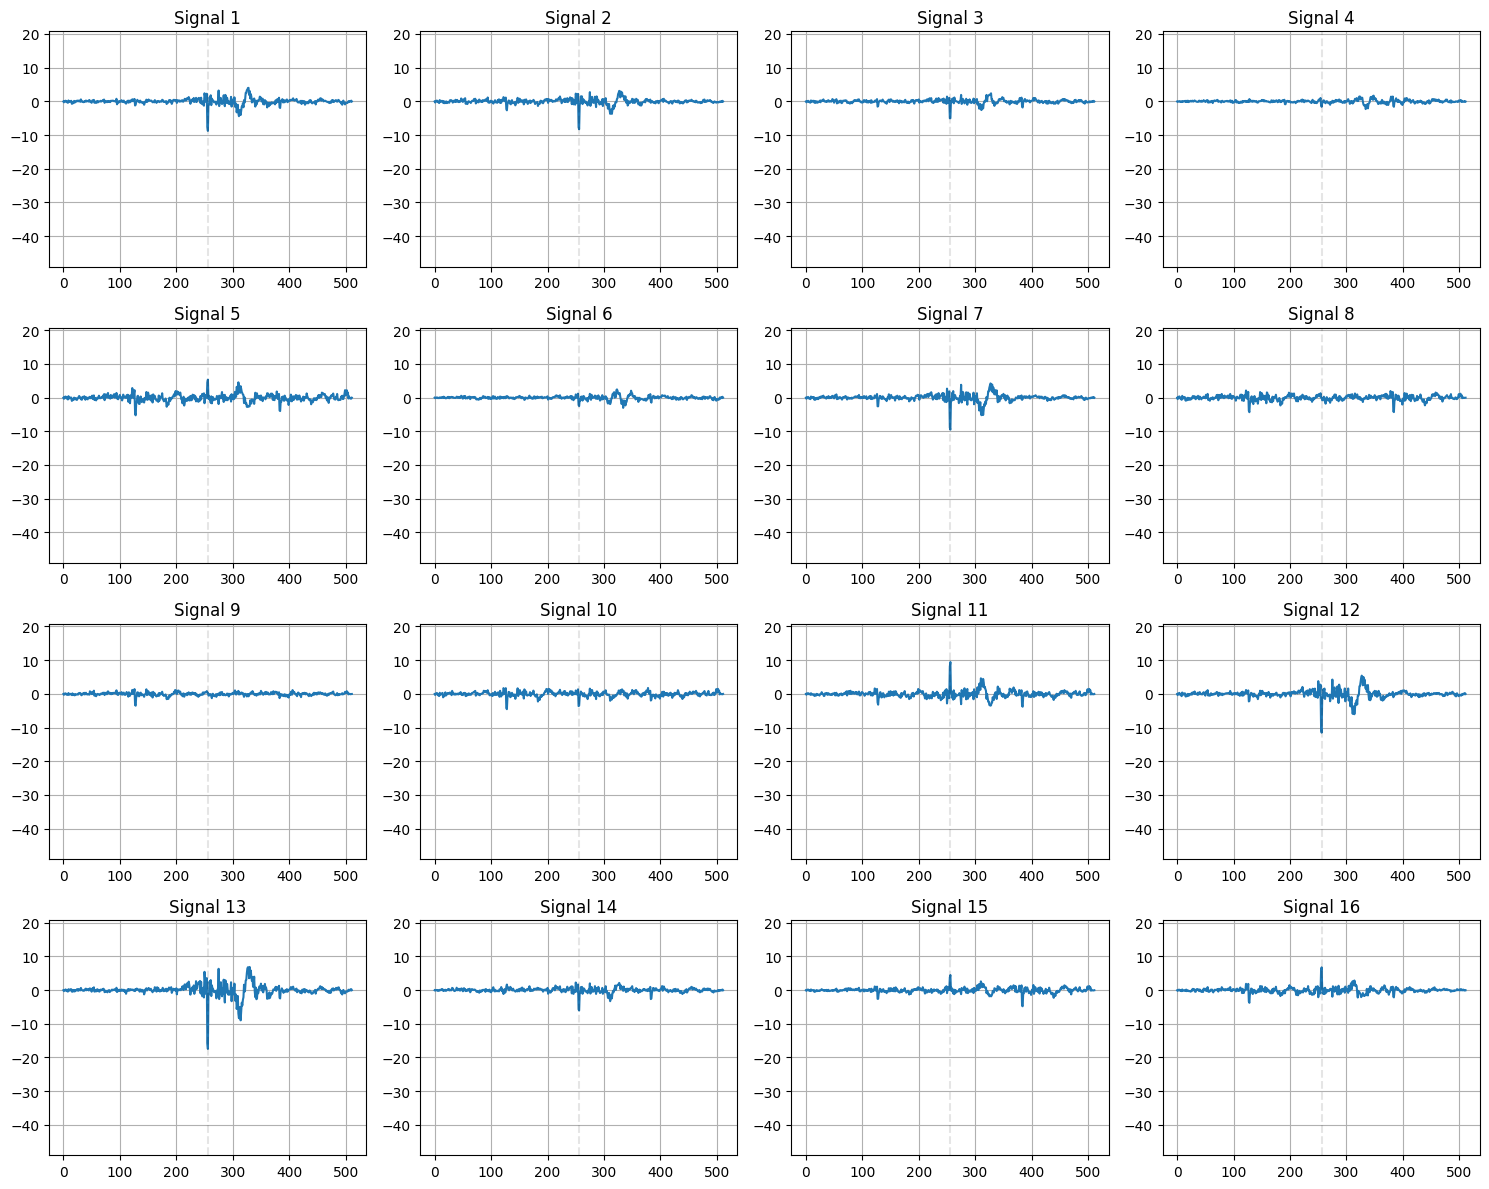

[11/32][0/56]	Loss_D: 1.3838	Loss_G: 2.6505	D(x): 0.3514	D(G(z)): 0.7511 / 0.8117
[11/32][50/56]	Loss_D: 0.4633	Loss_G: 2.0149	D(x): 0.1124	D(G(z)): 0.7055 / 0.7809


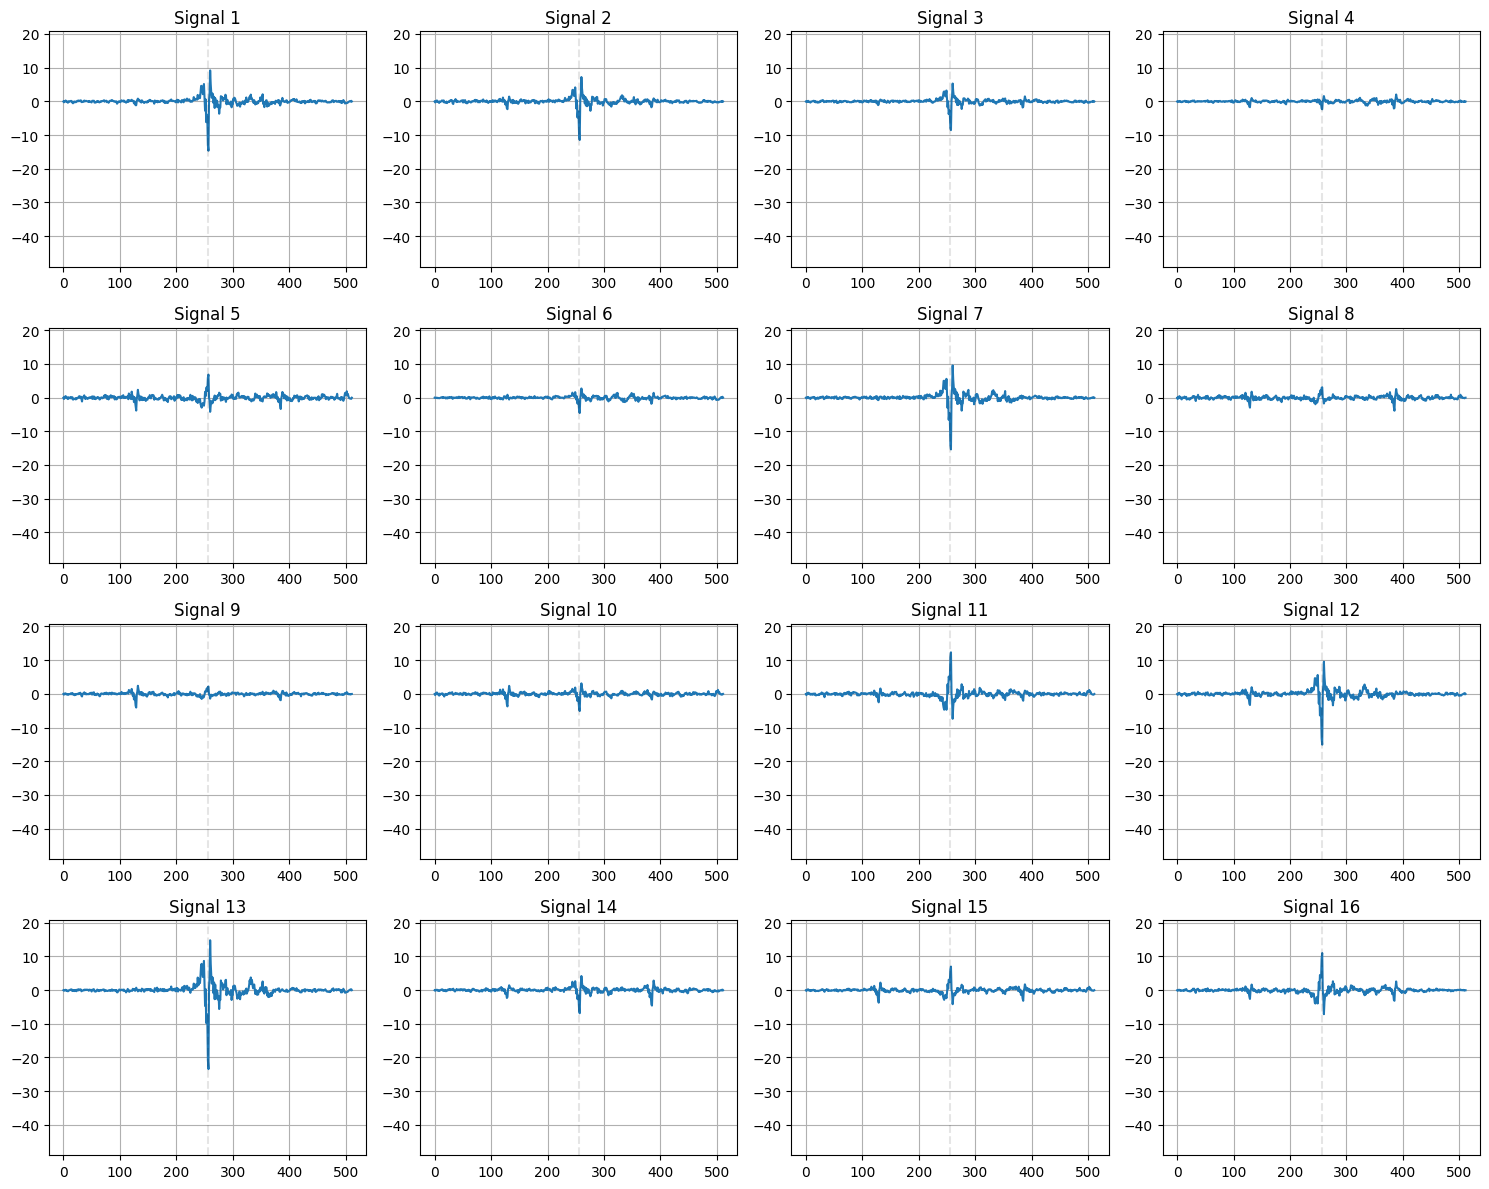

[12/32][0/56]	Loss_D: 0.7883	Loss_G: 2.6875	D(x): 0.0946	D(G(z)): 0.7903 / 0.8030
[12/32][50/56]	Loss_D: 1.2821	Loss_G: 4.9868	D(x): 0.1409	D(G(z)): 0.8405 / 0.7672


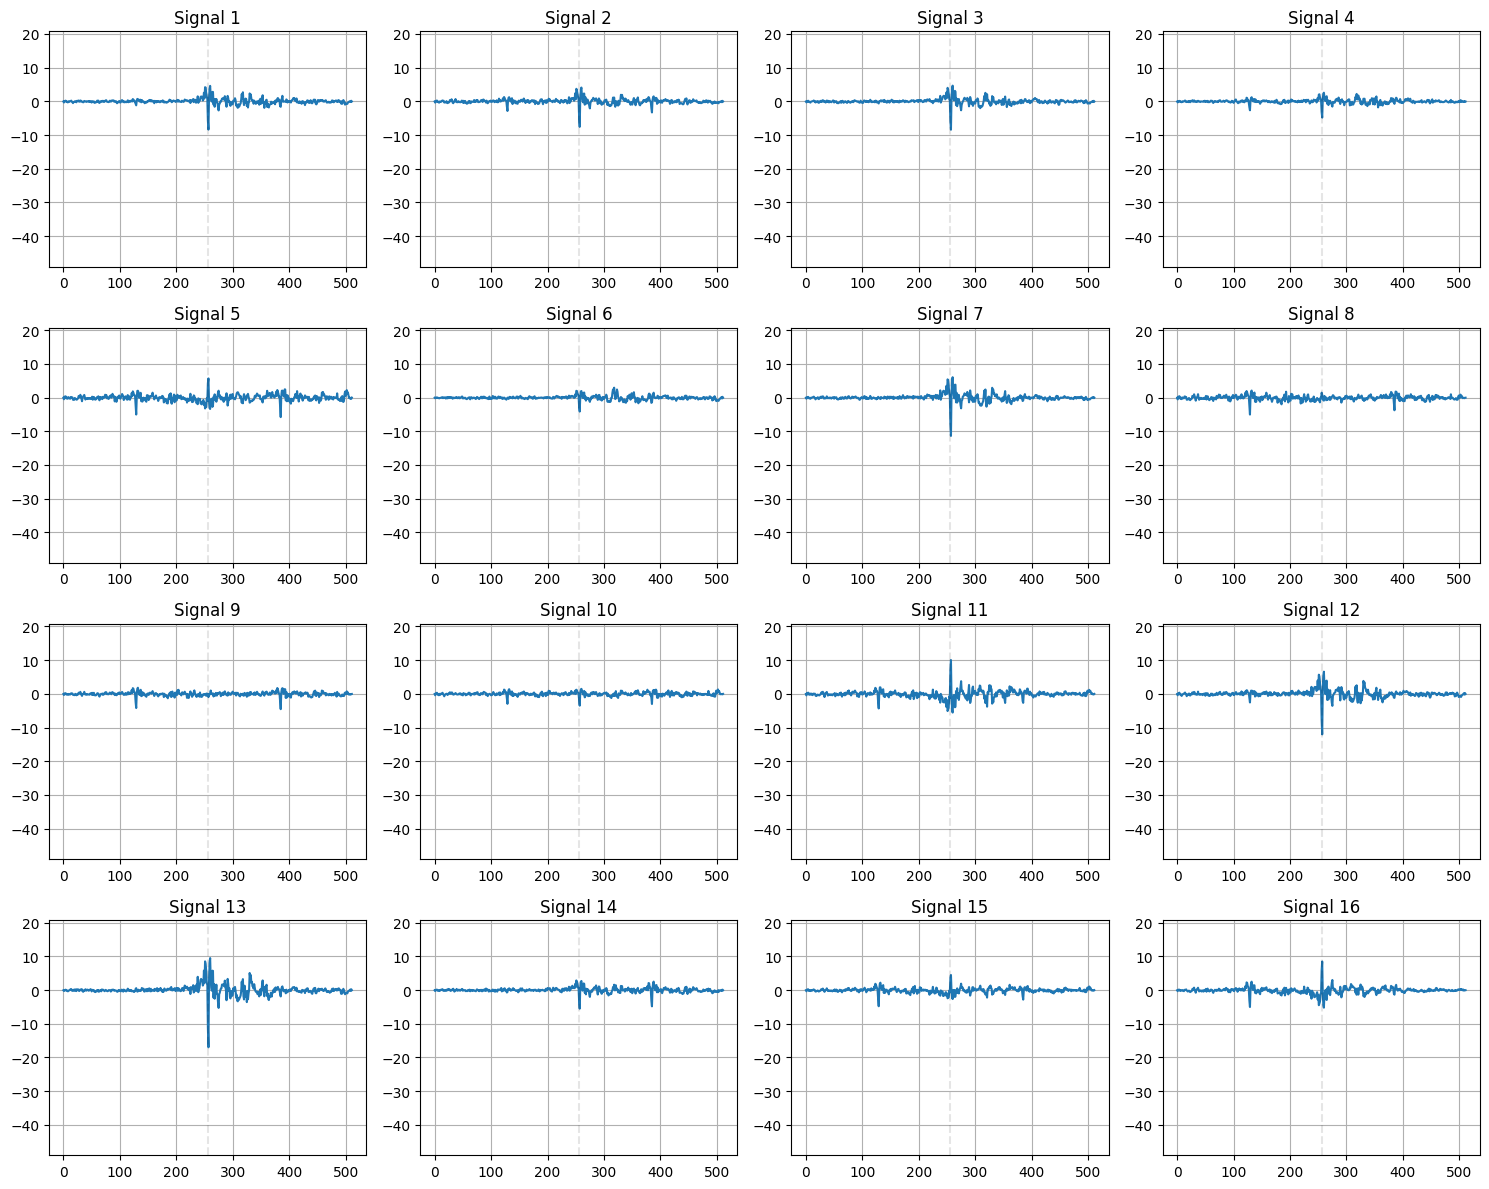

[13/32][0/56]	Loss_D: 0.6184	Loss_G: 1.8948	D(x): 0.0938	D(G(z)): 0.7581 / 0.7829
[13/32][50/56]	Loss_D: 0.8400	Loss_G: 1.7573	D(x): 0.2090	D(G(z)): 0.7311 / 0.7661


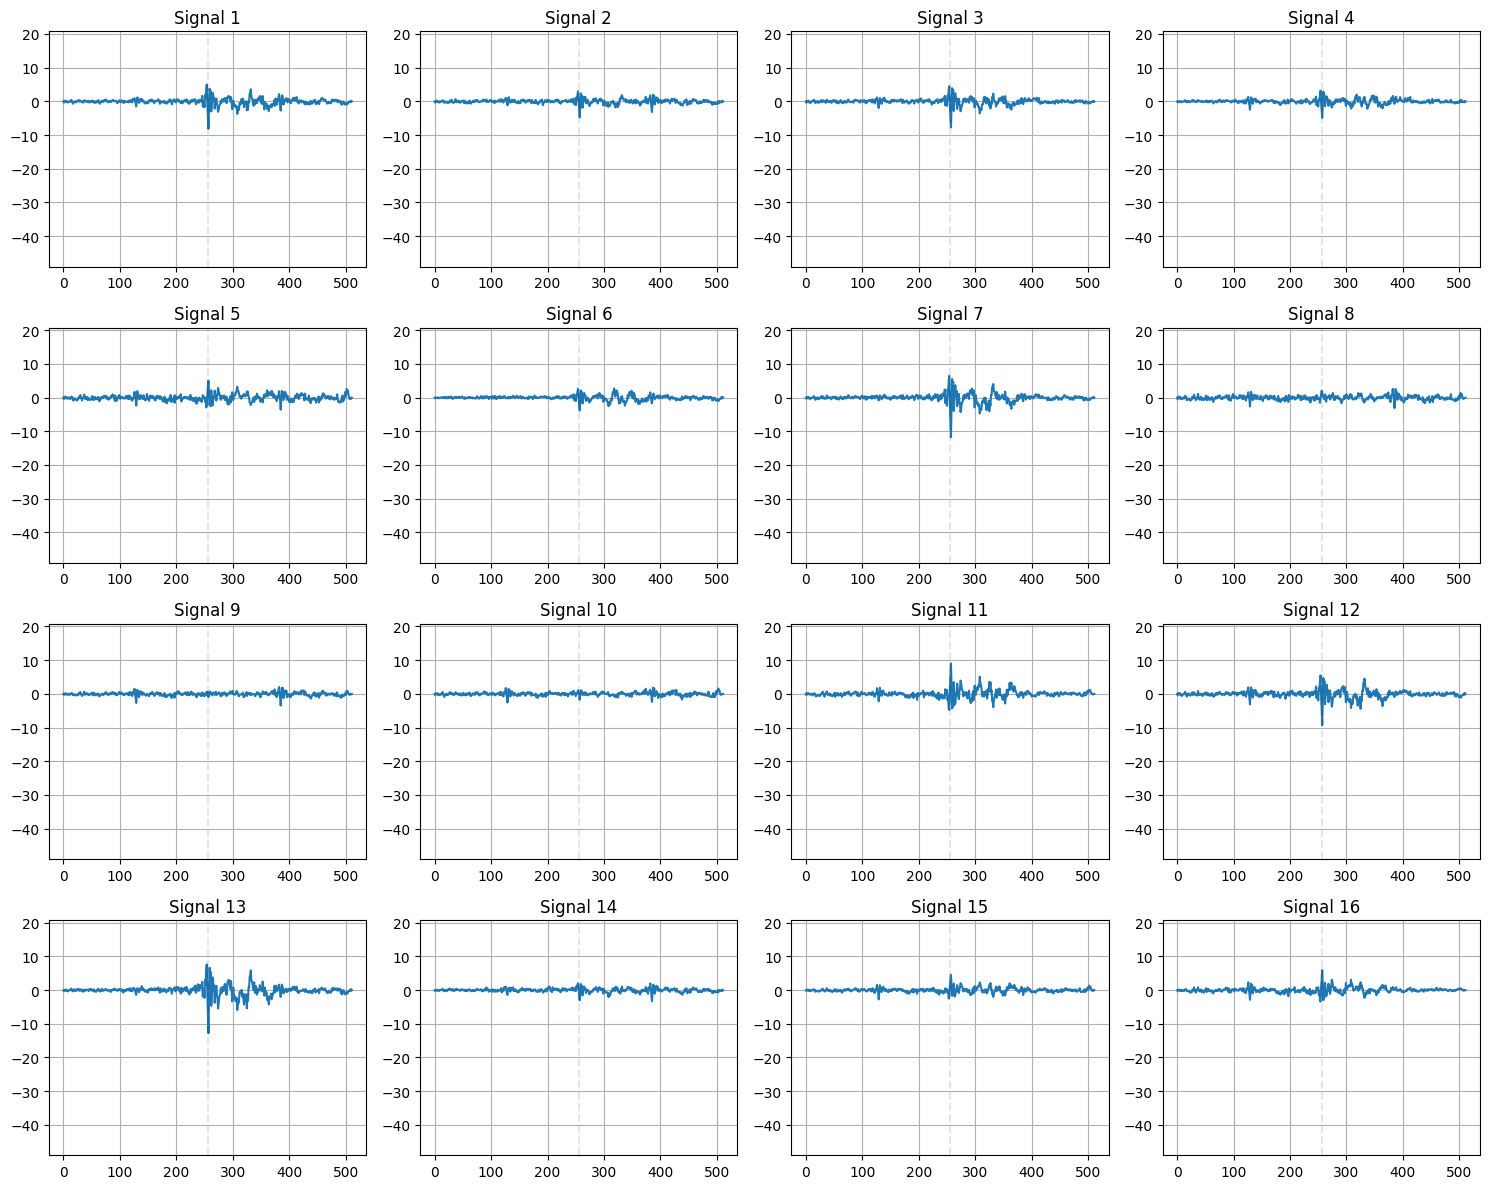

[14/32][0/56]	Loss_D: 0.7444	Loss_G: 1.3625	D(x): 0.1252	D(G(z)): 0.7085 / 0.6061
[14/32][50/56]	Loss_D: 0.8737	Loss_G: 2.3174	D(x): 0.1261	D(G(z)): 0.7603 / 0.8136


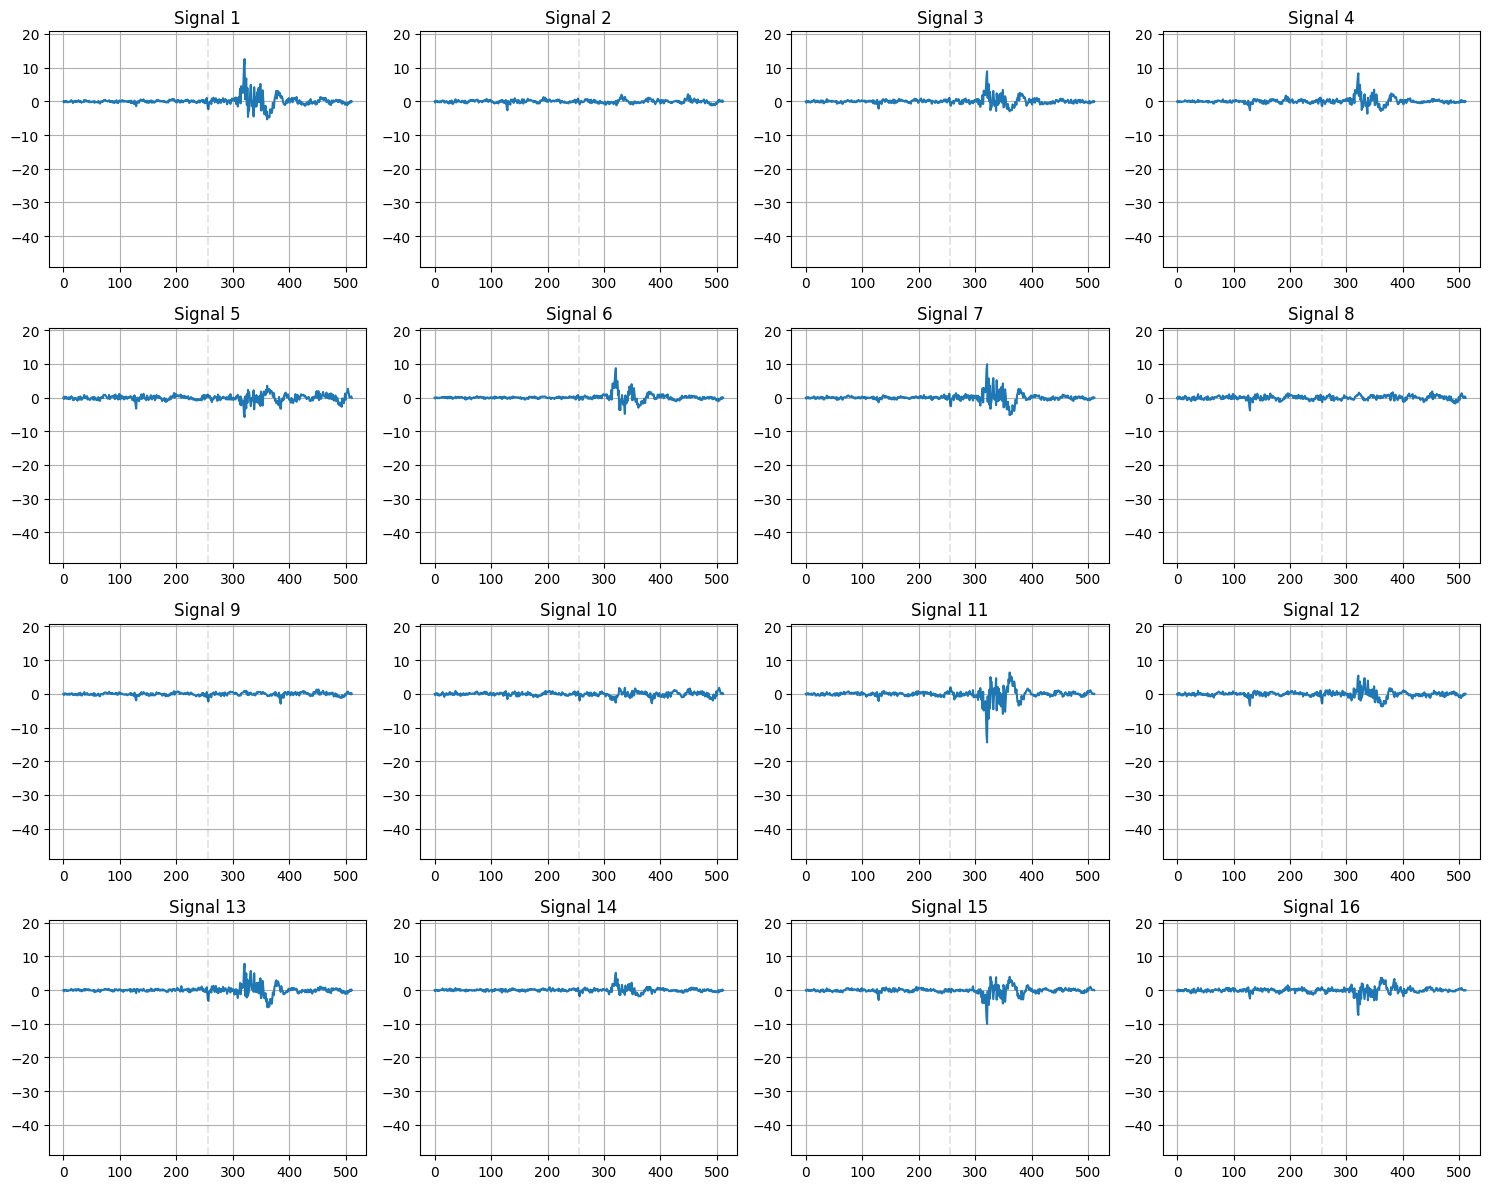

[15/32][0/56]	Loss_D: 0.4494	Loss_G: 1.9326	D(x): 0.1100	D(G(z)): 0.7183 / 0.7605
[15/32][50/56]	Loss_D: 0.7909	Loss_G: 1.6227	D(x): 0.0948	D(G(z)): 0.7878 / 0.7352


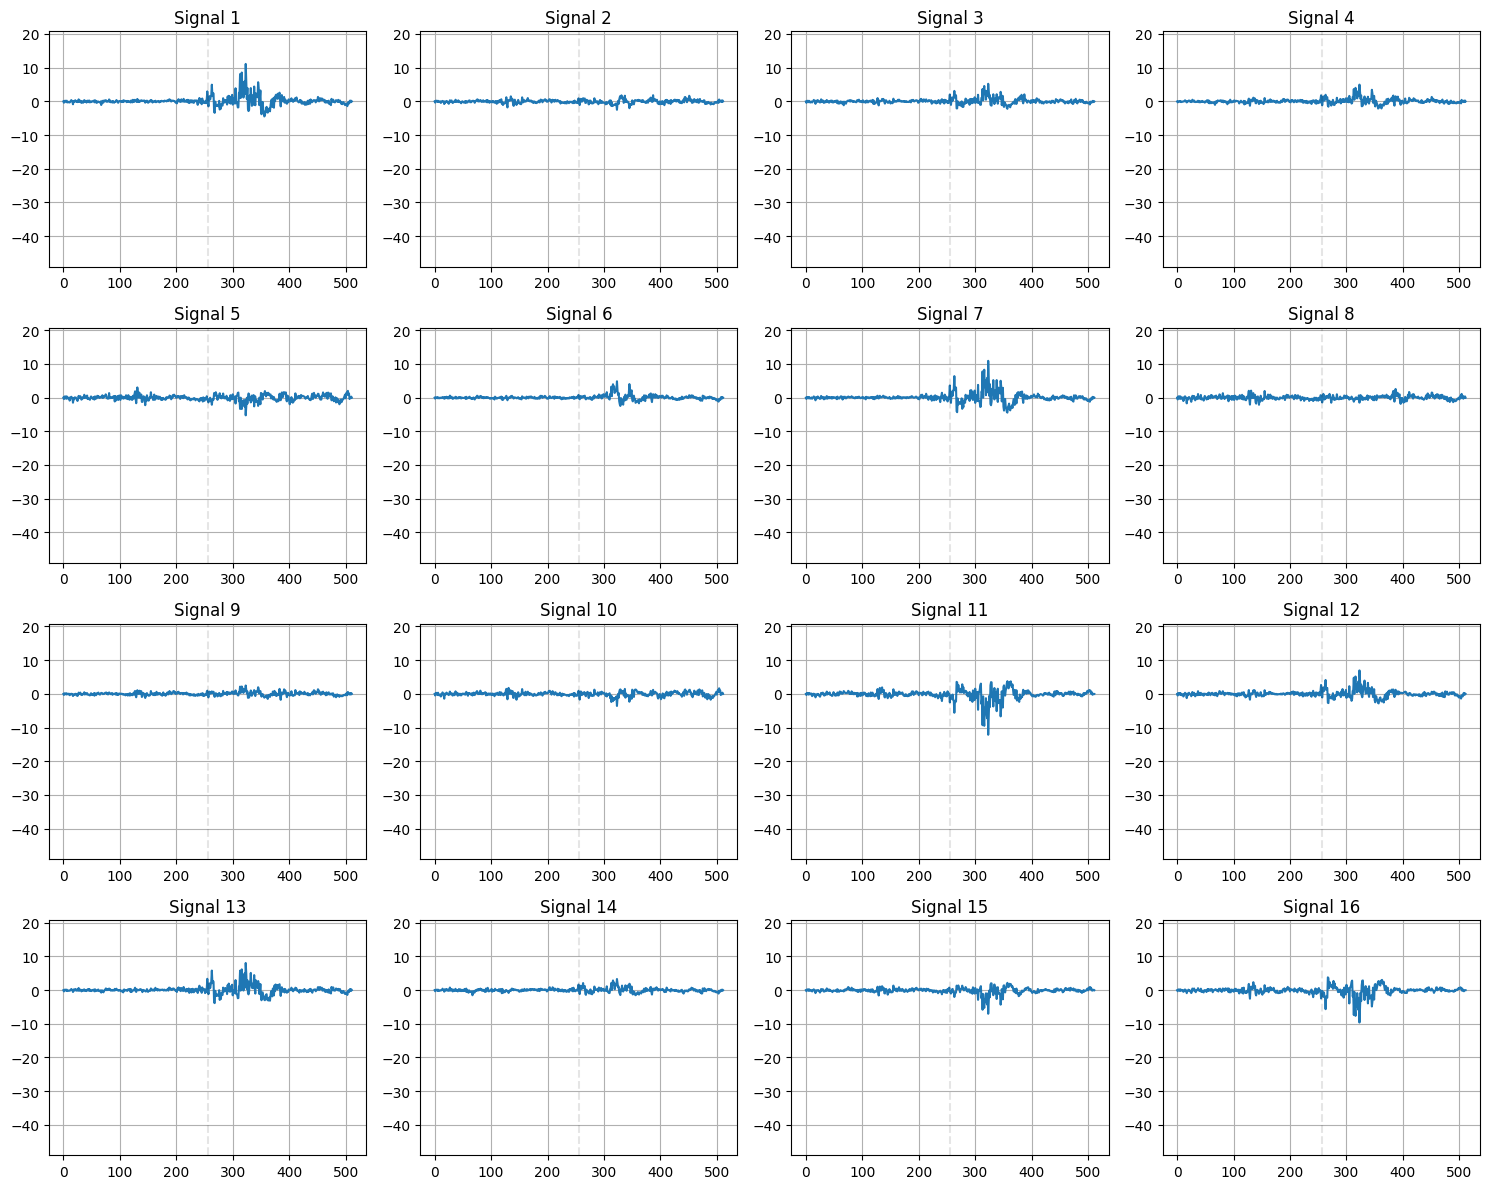

[16/32][0/56]	Loss_D: 0.4915	Loss_G: 2.1430	D(x): 0.0942	D(G(z)): 0.6454 / 0.7652
[16/32][50/56]	Loss_D: 0.5549	Loss_G: 2.6939	D(x): 0.1417	D(G(z)): 0.7582 / 0.8646


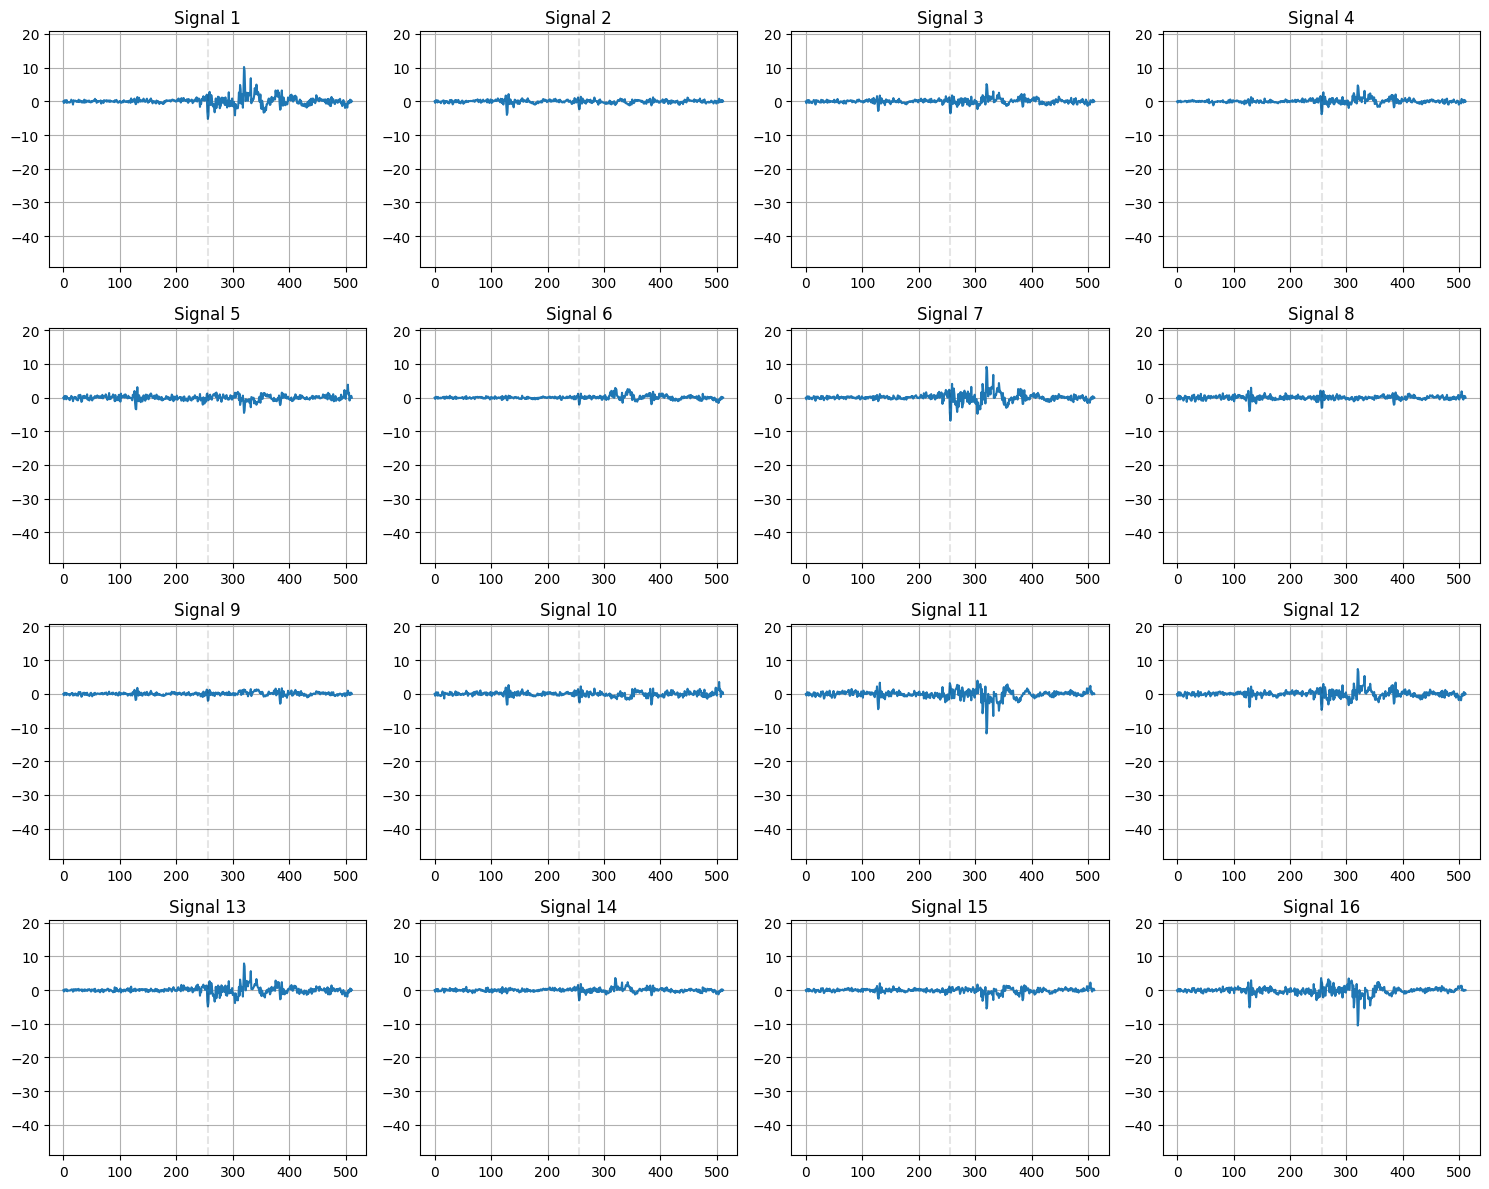

[17/32][0/56]	Loss_D: 1.4968	Loss_G: 10.4842	D(x): 0.1932	D(G(z)): 0.7953 / 0.8336
[17/32][50/56]	Loss_D: 1.1127	Loss_G: 2.2572	D(x): 0.2042	D(G(z)): 0.7525 / 0.7570


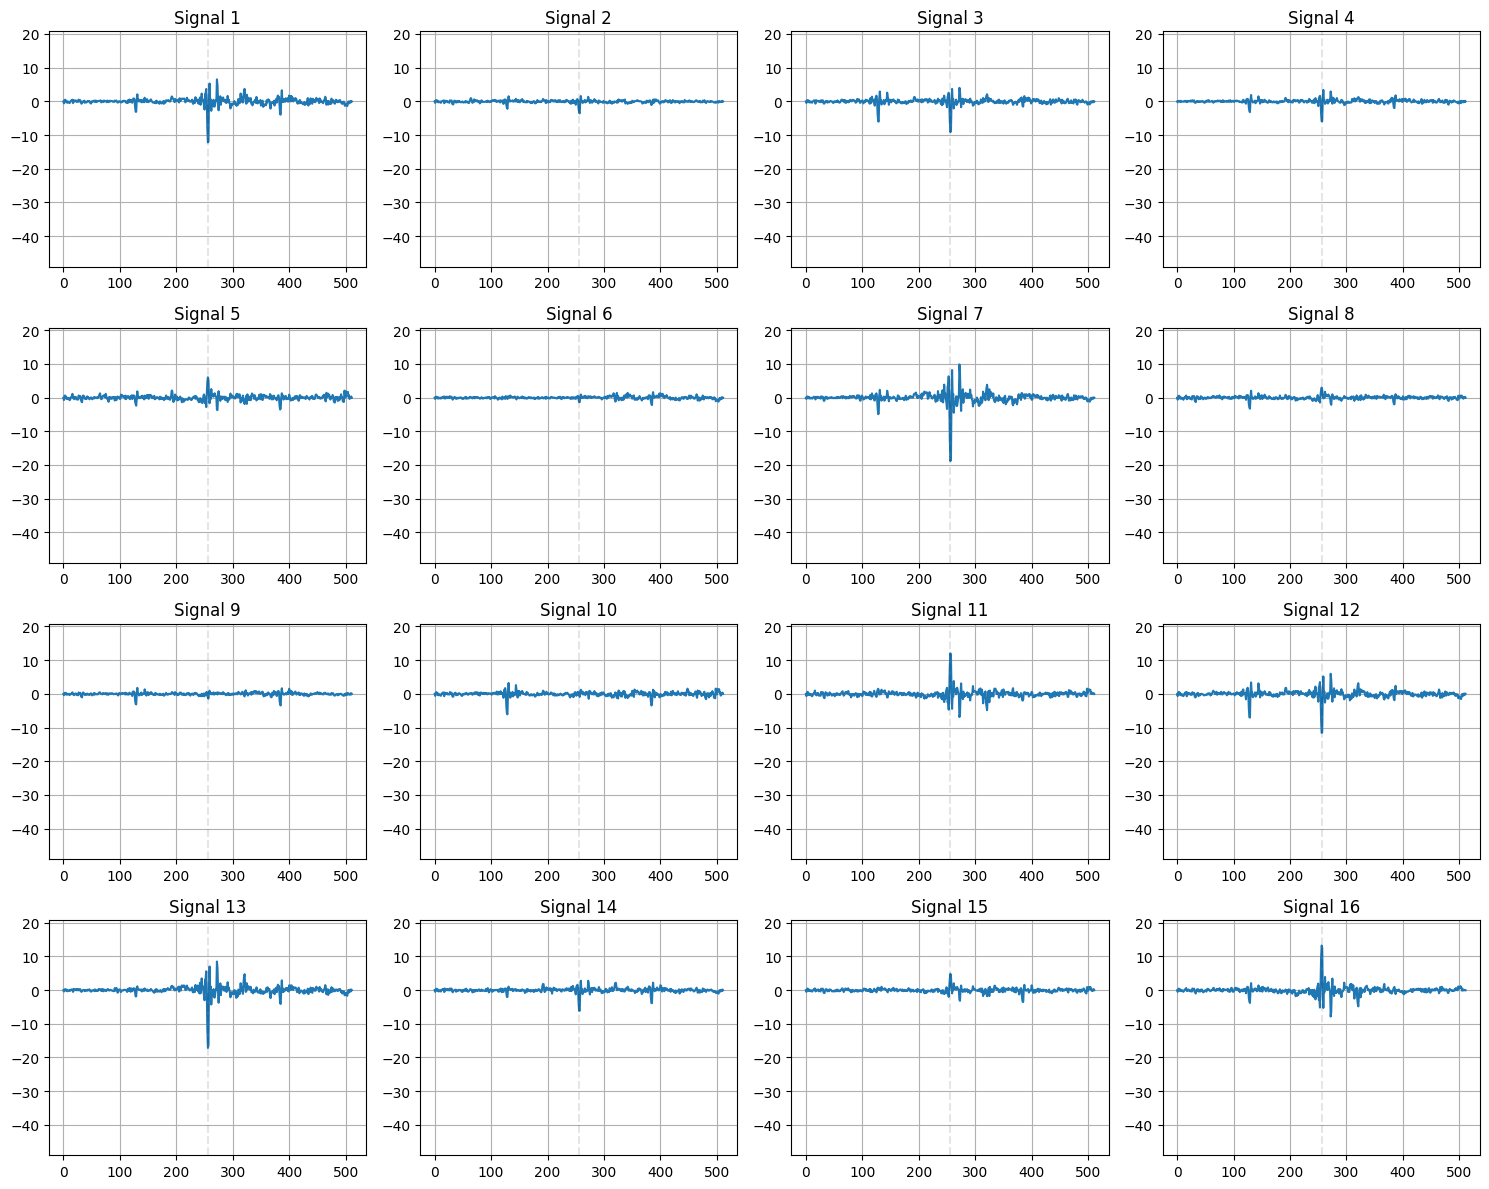

[18/32][0/56]	Loss_D: 0.6811	Loss_G: 2.5470	D(x): 0.1366	D(G(z)): 0.8533 / 0.7933
[18/32][50/56]	Loss_D: 0.7975	Loss_G: 2.0484	D(x): 0.0664	D(G(z)): 0.8064 / 0.7970


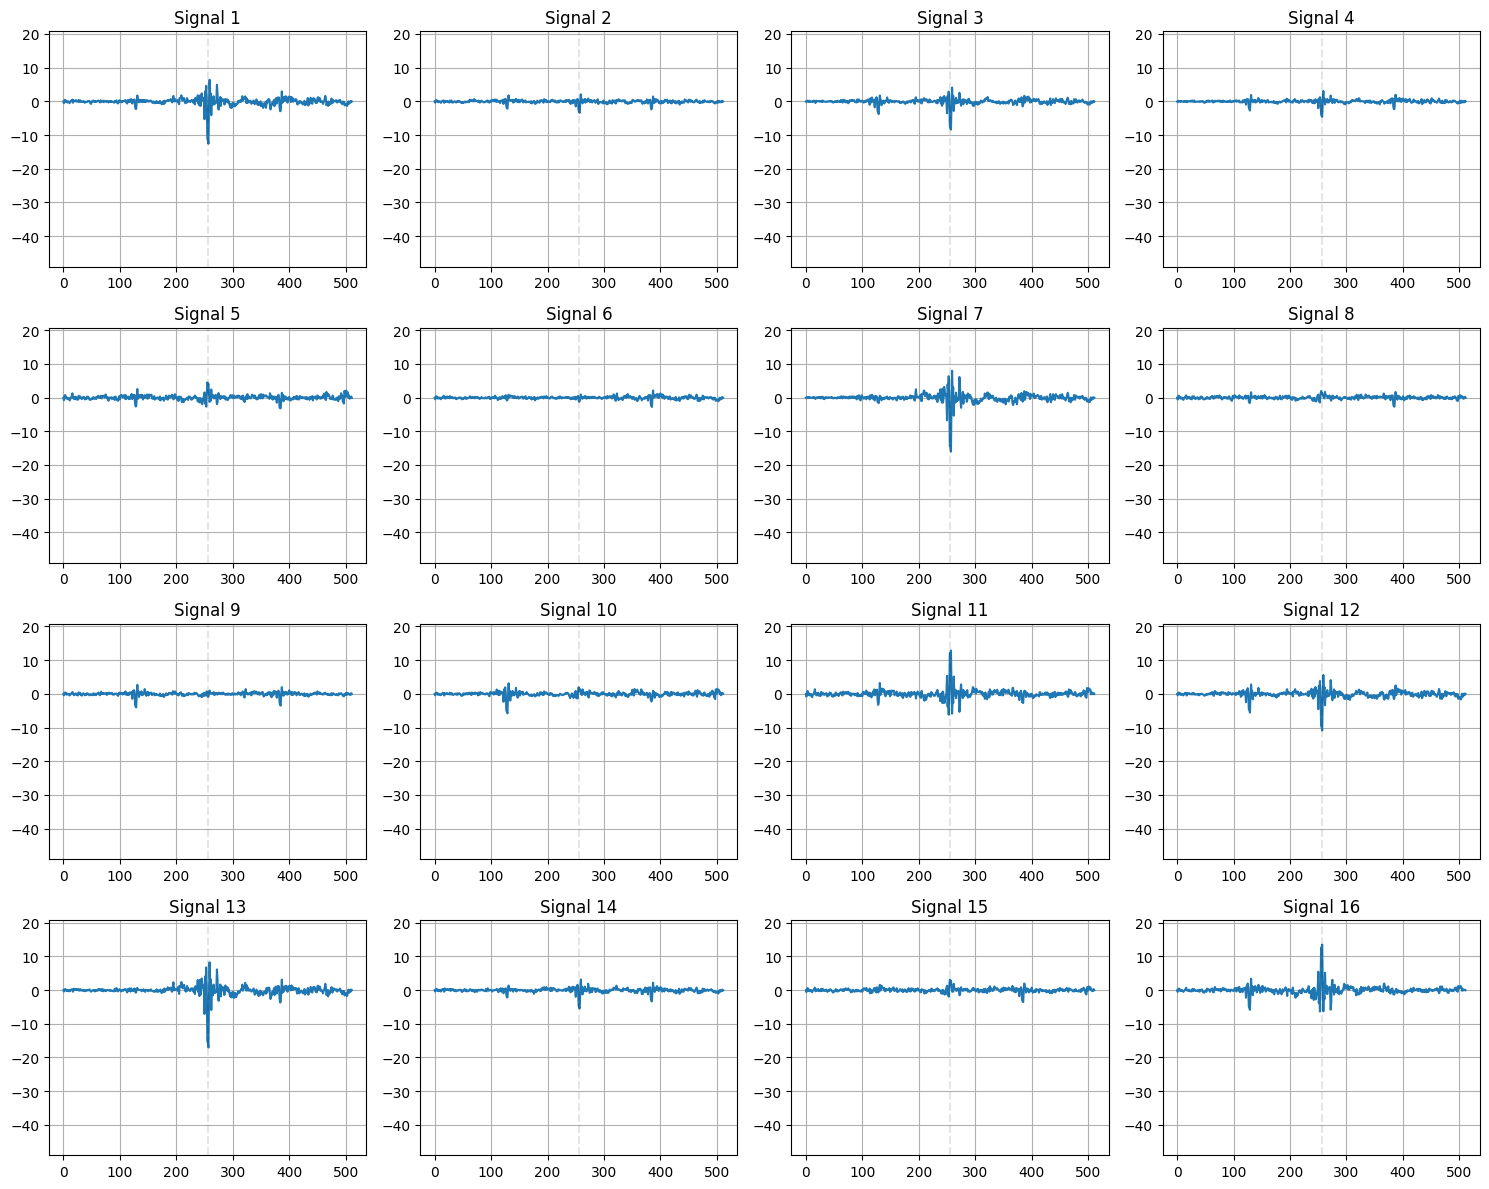

[19/32][0/56]	Loss_D: 0.8359	Loss_G: 1.5313	D(x): 0.1764	D(G(z)): 0.7141 / 0.7027
[19/32][50/56]	Loss_D: 0.8240	Loss_G: 1.8991	D(x): 0.1719	D(G(z)): 0.7483 / 0.8050


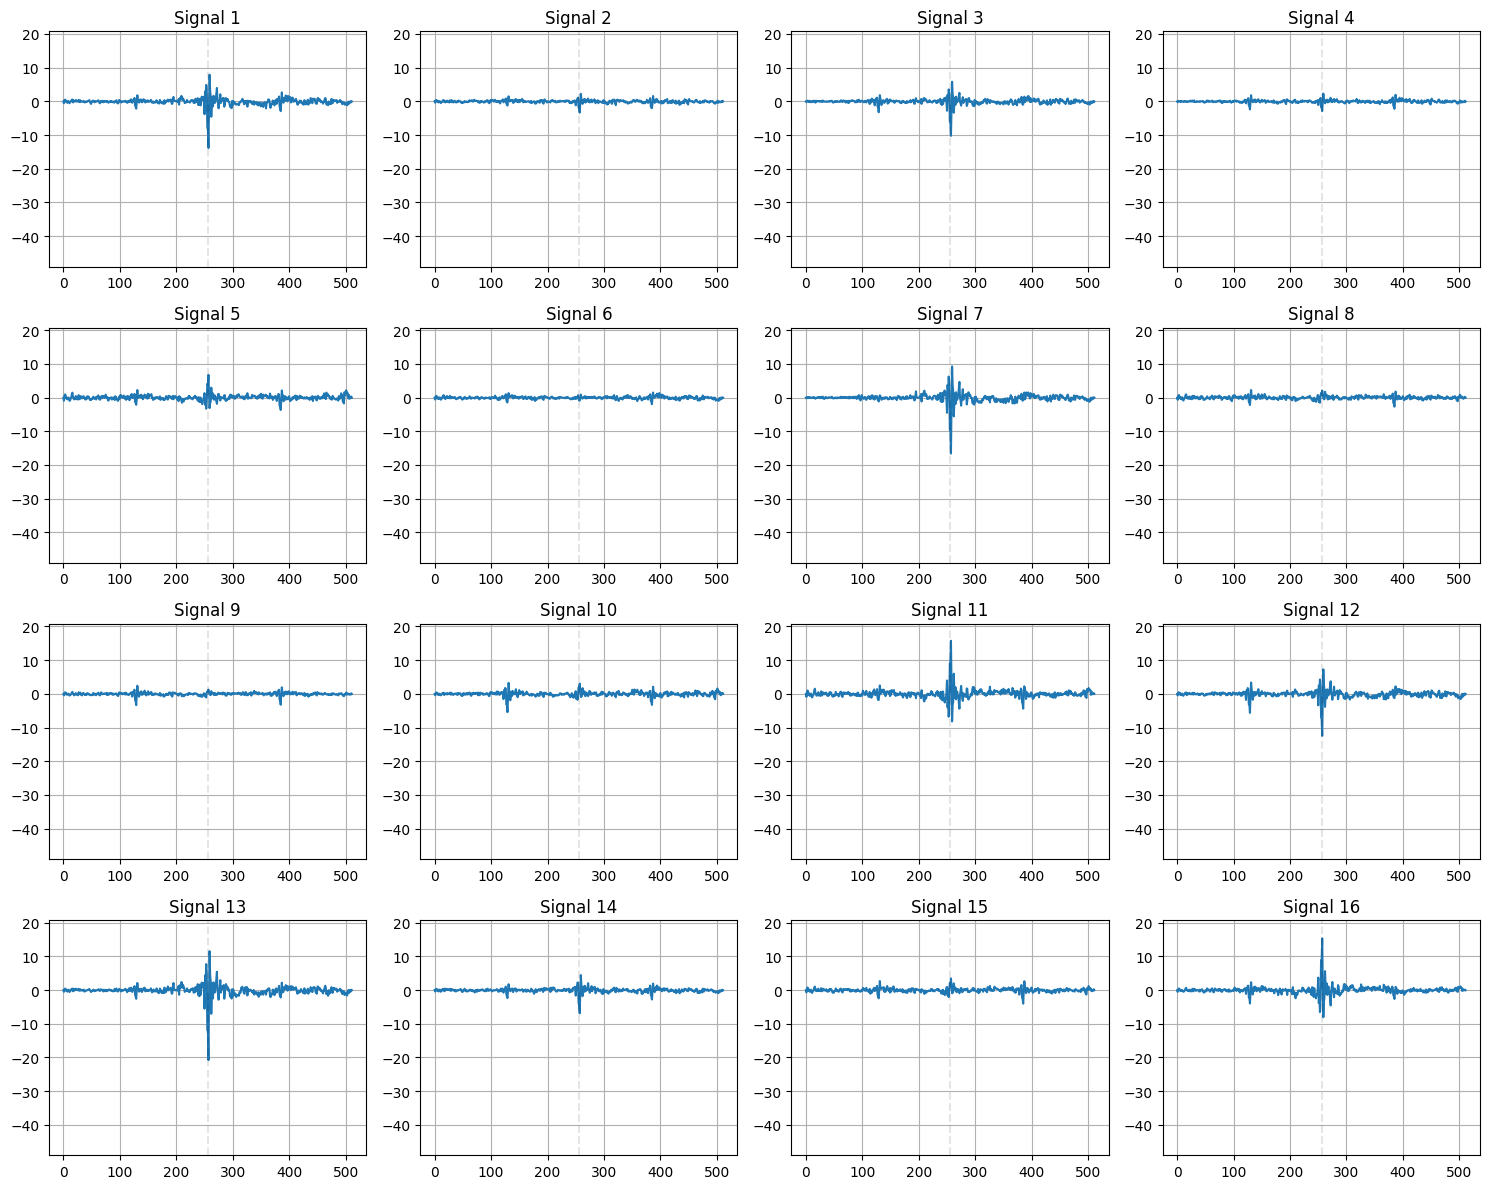

[20/32][0/56]	Loss_D: 1.0637	Loss_G: 2.5100	D(x): 0.1415	D(G(z)): 0.8590 / 0.8146
[20/32][50/56]	Loss_D: 0.3735	Loss_G: 2.3705	D(x): 0.1264	D(G(z)): 0.7399 / 0.8289


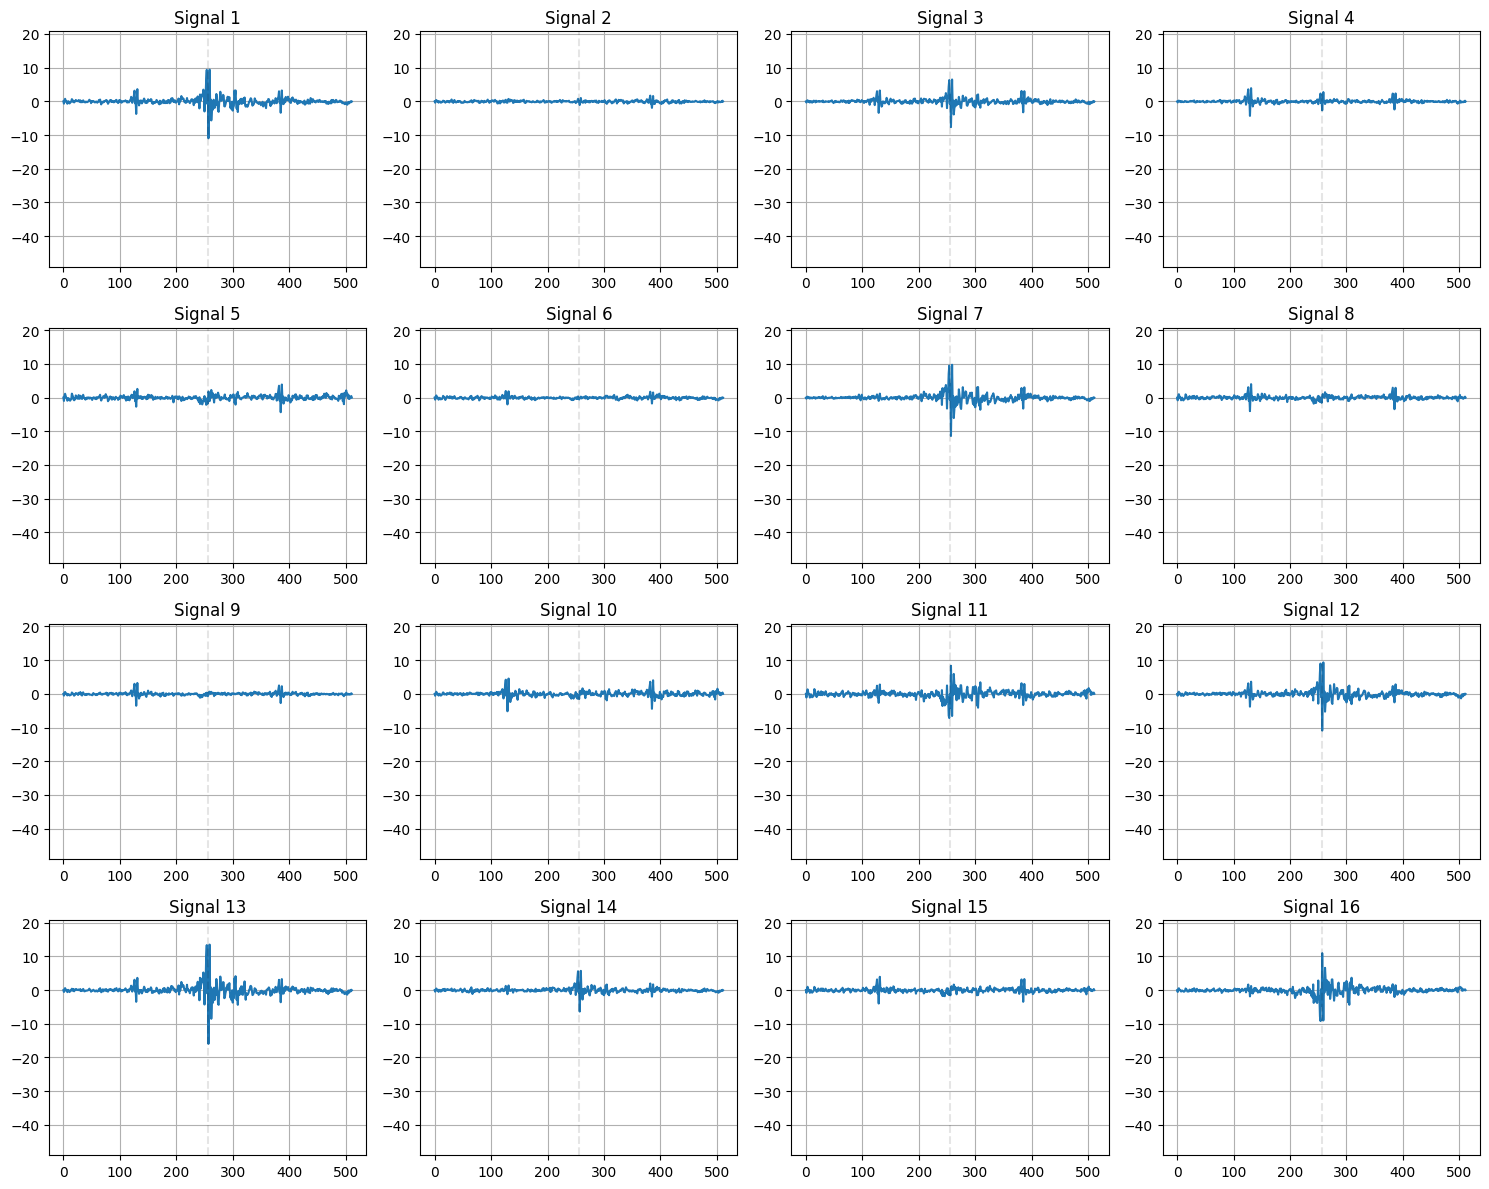

[21/32][0/56]	Loss_D: 0.7581	Loss_G: 2.1047	D(x): 0.0784	D(G(z)): 0.8851 / 0.7887
[21/32][50/56]	Loss_D: 0.1273	Loss_G: 1.9796	D(x): 0.1876	D(G(z)): 0.7769 / 0.7874


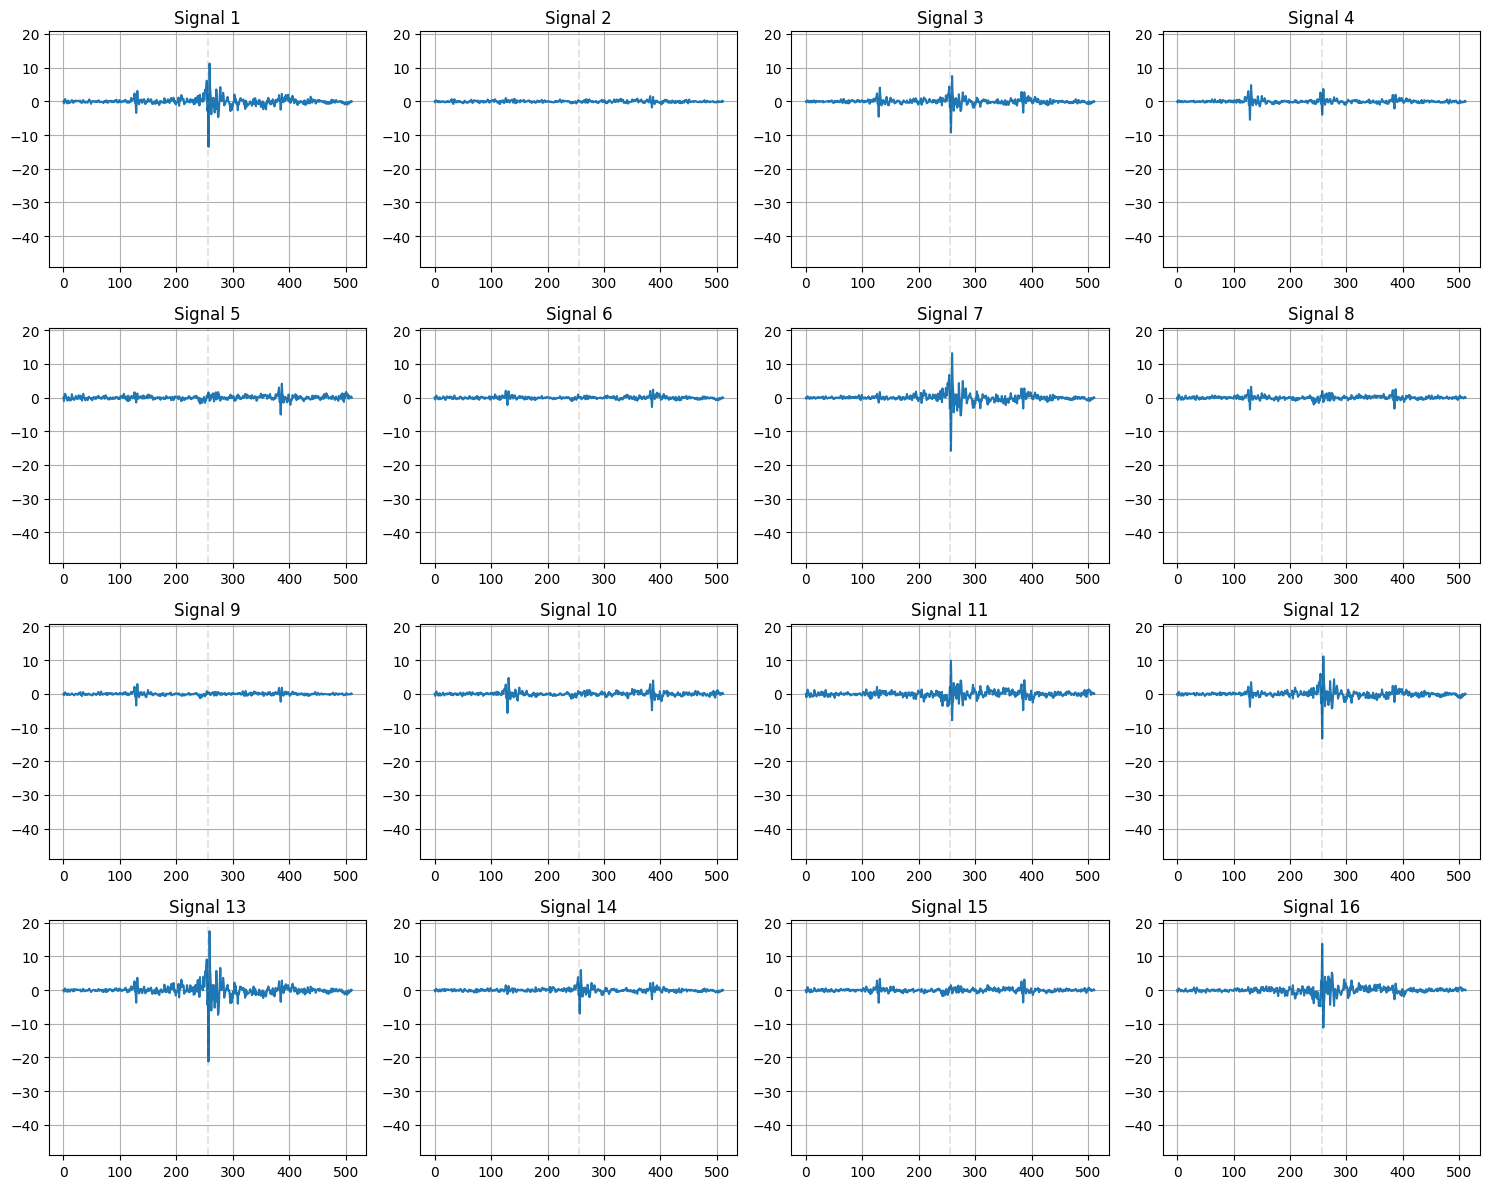

[22/32][0/56]	Loss_D: 1.5109	Loss_G: 2.6036	D(x): 0.1250	D(G(z)): 0.4447 / 0.7651
[22/32][50/56]	Loss_D: 0.7833	Loss_G: 2.1476	D(x): 0.0939	D(G(z)): 0.7057 / 0.7995


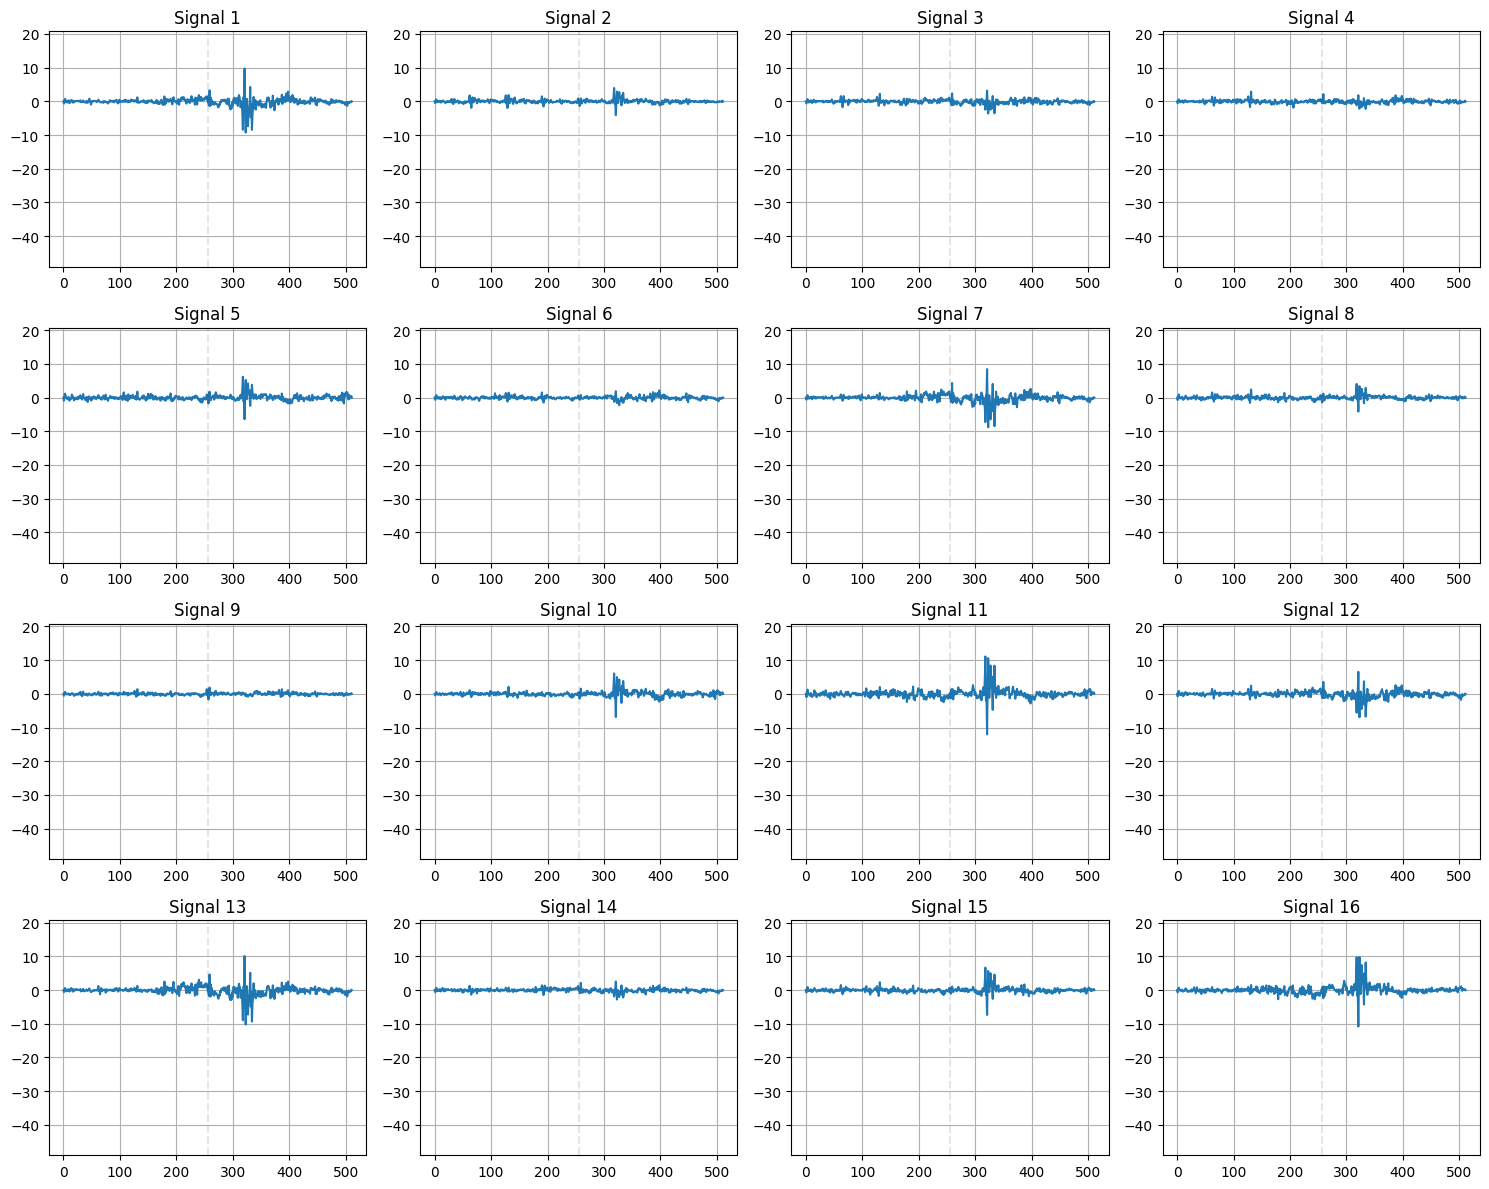

[23/32][0/56]	Loss_D: 0.8046	Loss_G: 2.8107	D(x): 0.0788	D(G(z)): 0.8486 / 0.8277
[23/32][50/56]	Loss_D: 0.4012	Loss_G: 2.4201	D(x): 0.1250	D(G(z)): 0.7606 / 0.7384


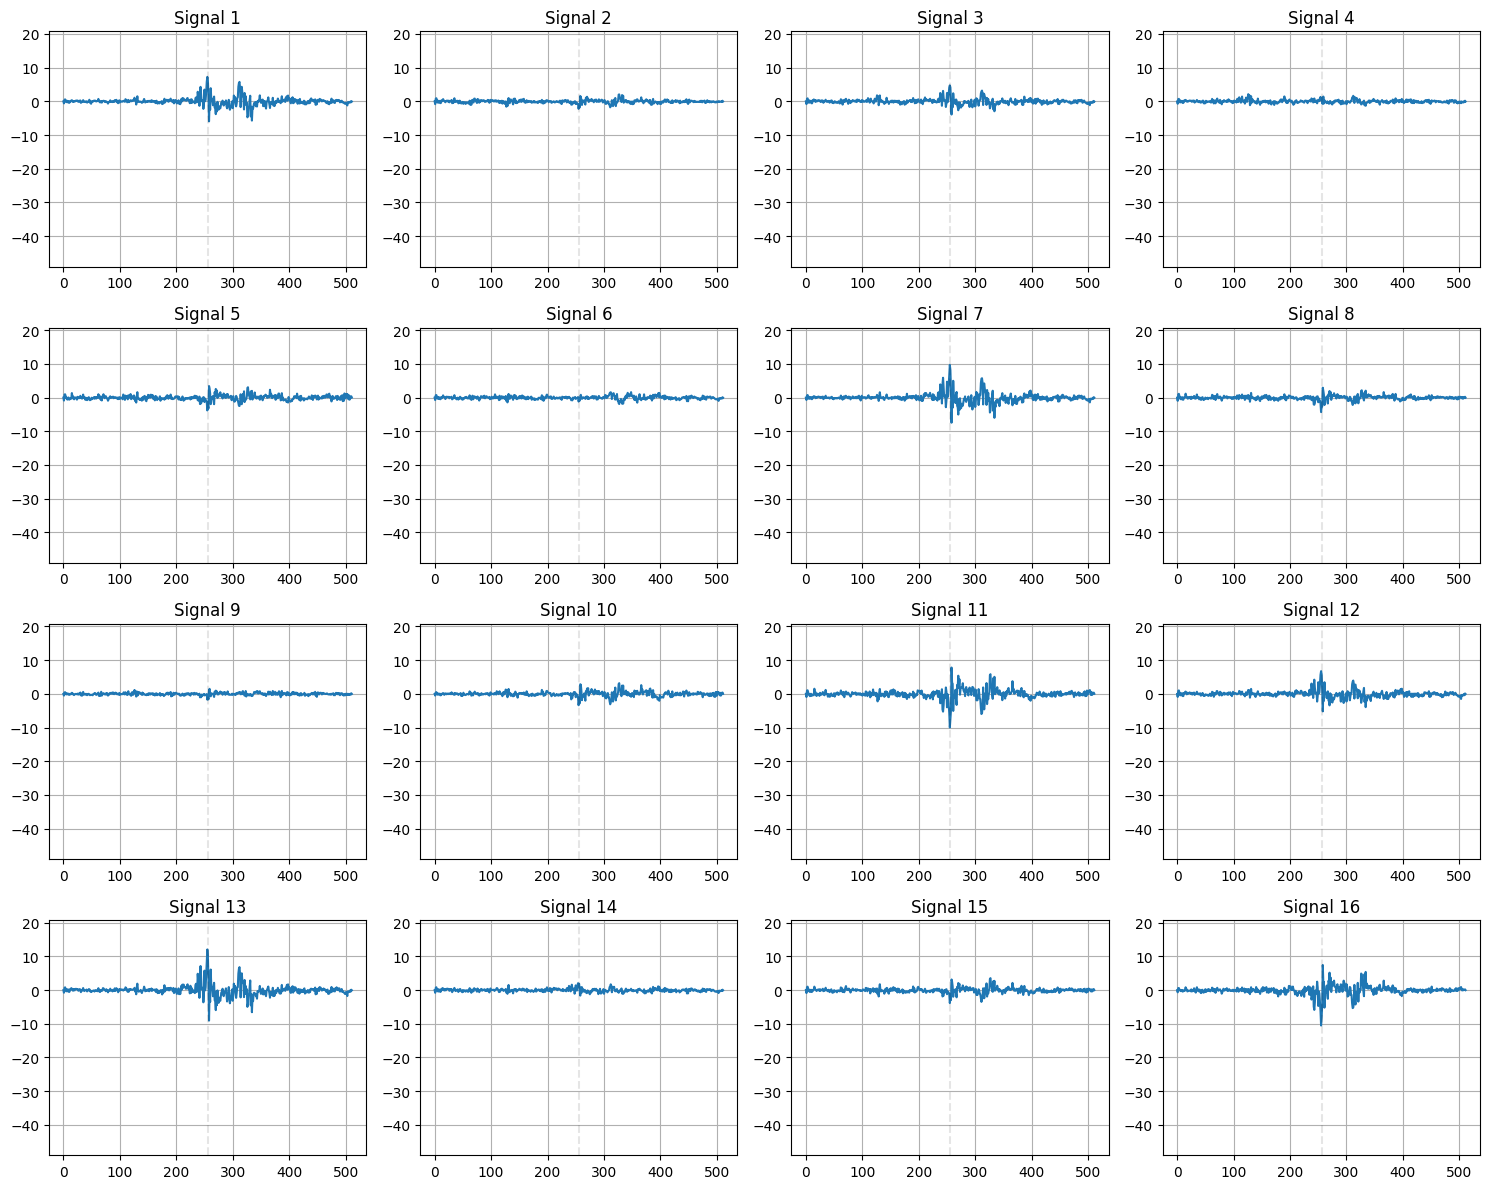

[24/32][0/56]	Loss_D: 0.4972	Loss_G: 1.5603	D(x): 0.0156	D(G(z)): 0.6771 / 0.7582
[24/32][50/56]	Loss_D: 0.4979	Loss_G: 2.0287	D(x): 0.1259	D(G(z)): 0.7809 / 0.7927


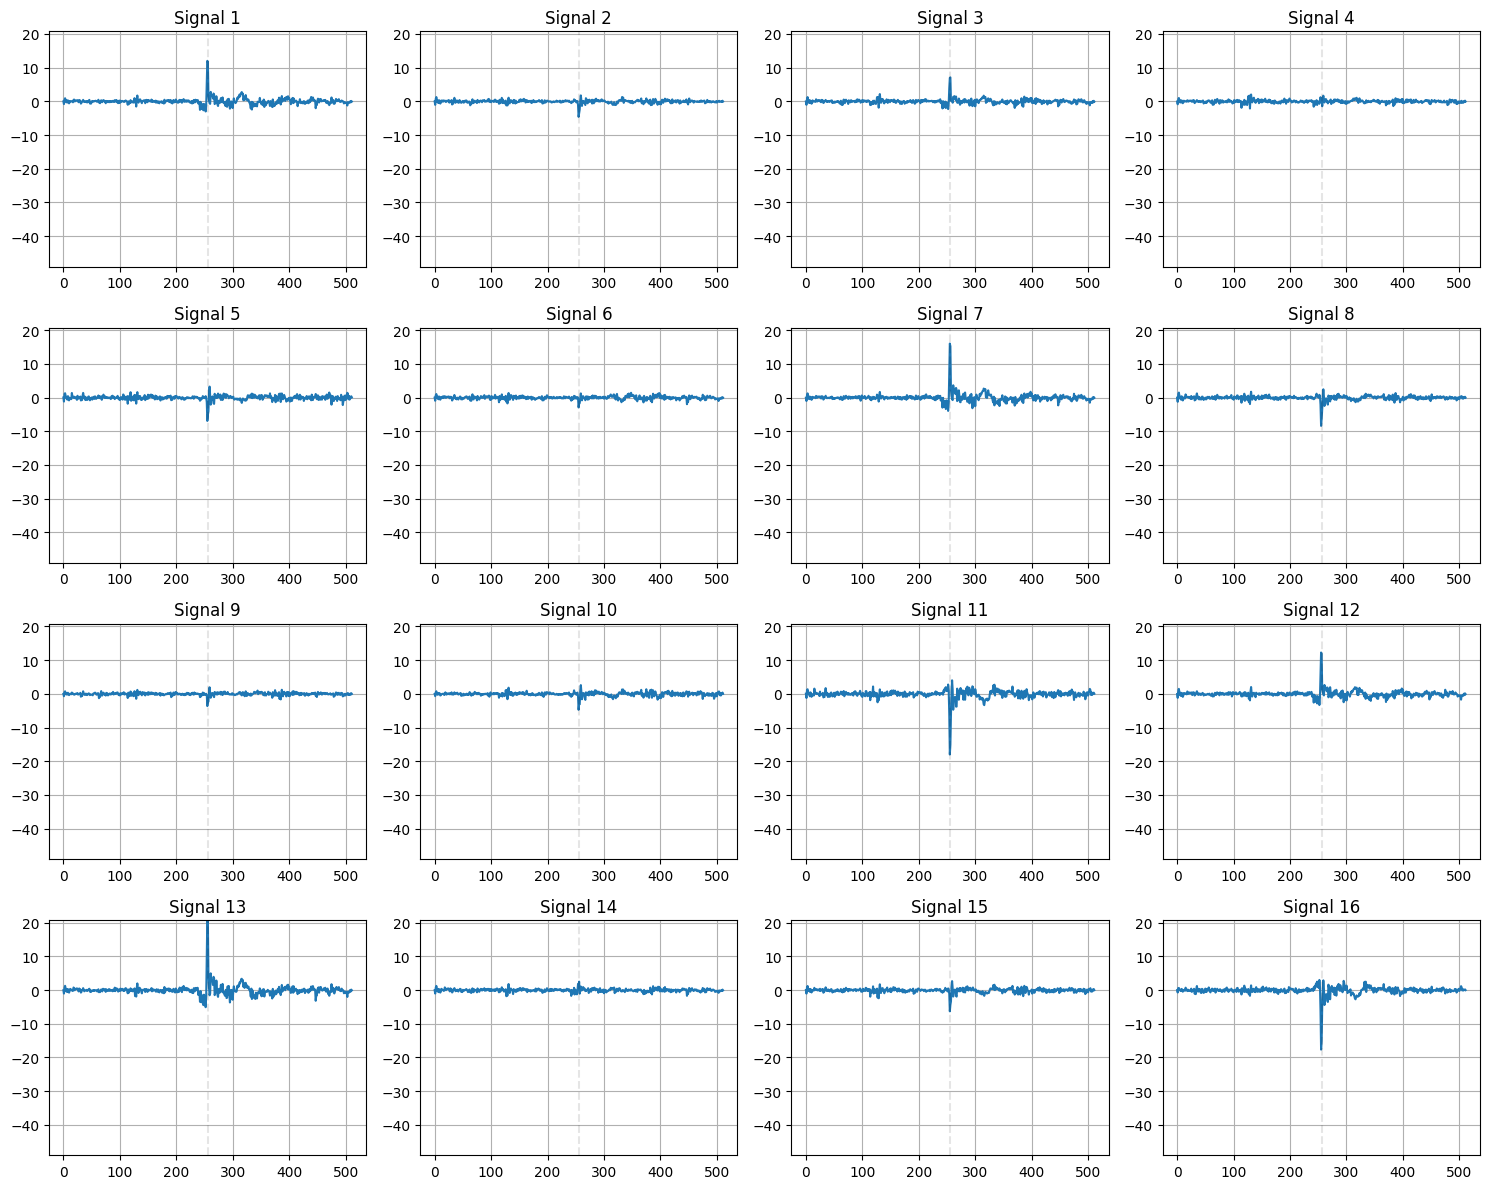

[25/32][0/56]	Loss_D: 0.7565	Loss_G: 1.5451	D(x): 0.2365	D(G(z)): 0.7555 / 0.7170
[25/32][50/56]	Loss_D: 0.9333	Loss_G: 3.0423	D(x): 0.1512	D(G(z)): 0.8462 / 0.8157


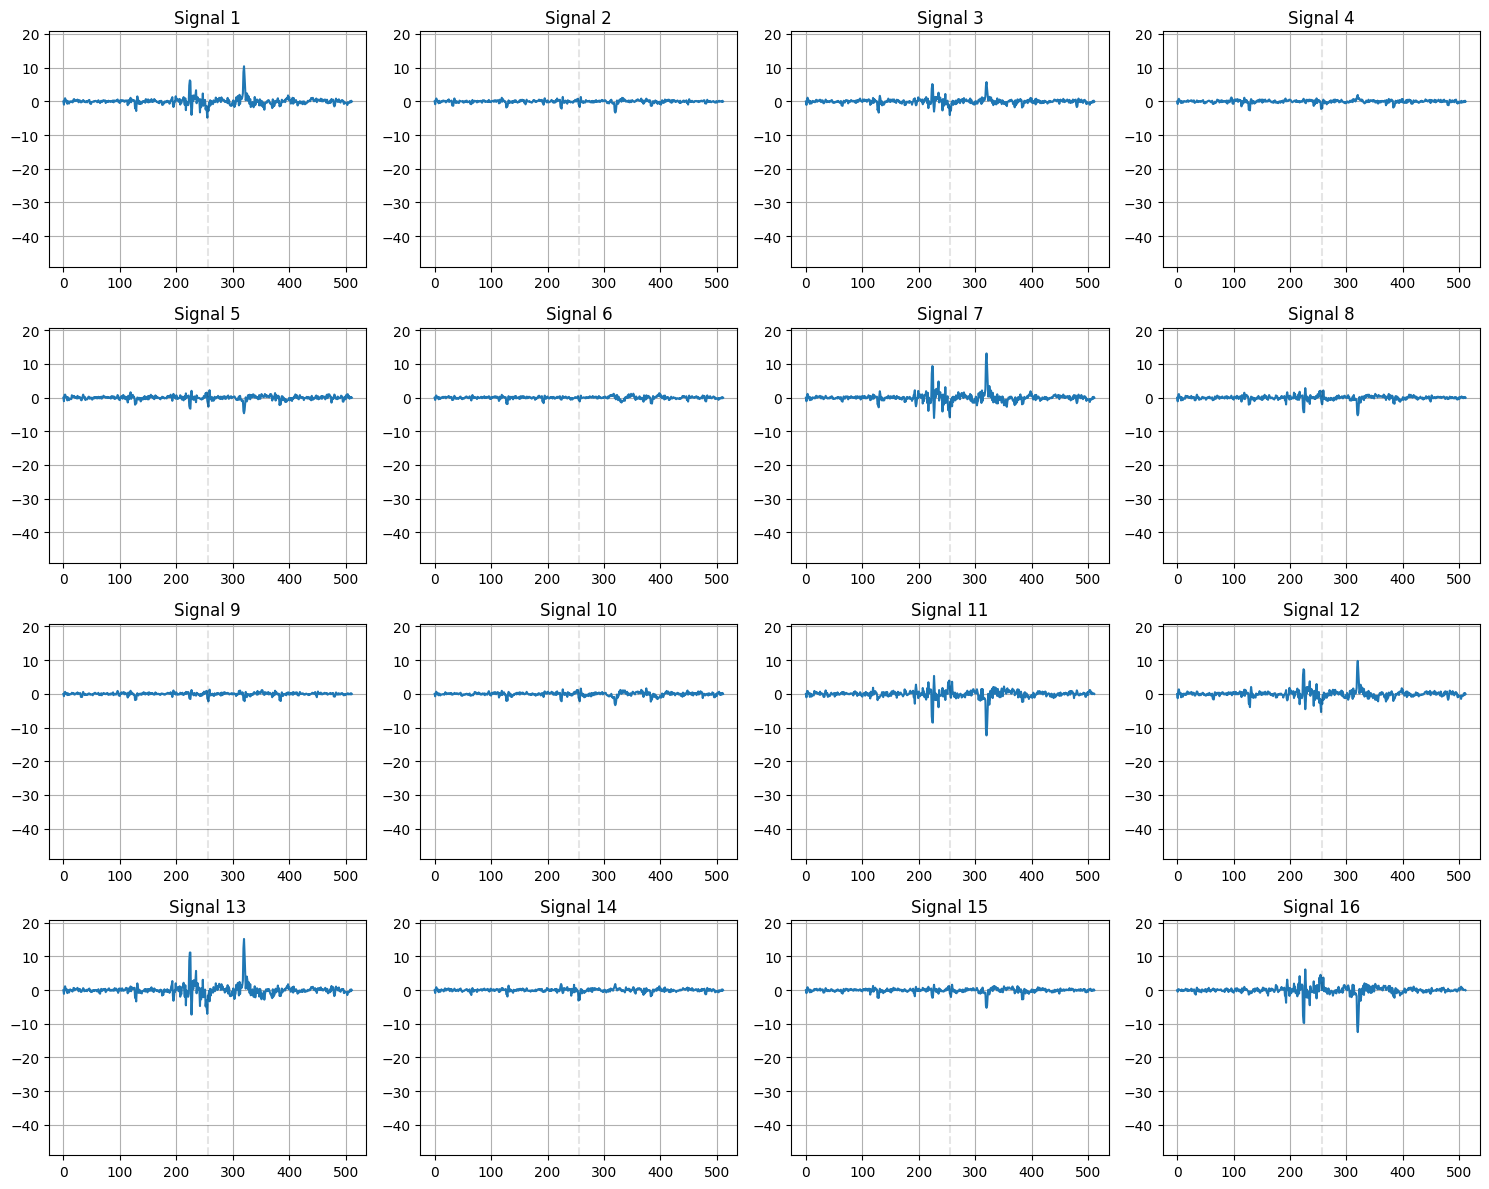

[26/32][0/56]	Loss_D: 0.4575	Loss_G: 1.4700	D(x): 0.1719	D(G(z)): 0.6966 / 0.7130
[26/32][50/56]	Loss_D: 0.6813	Loss_G: 1.6459	D(x): 0.1741	D(G(z)): 0.6825 / 0.7399


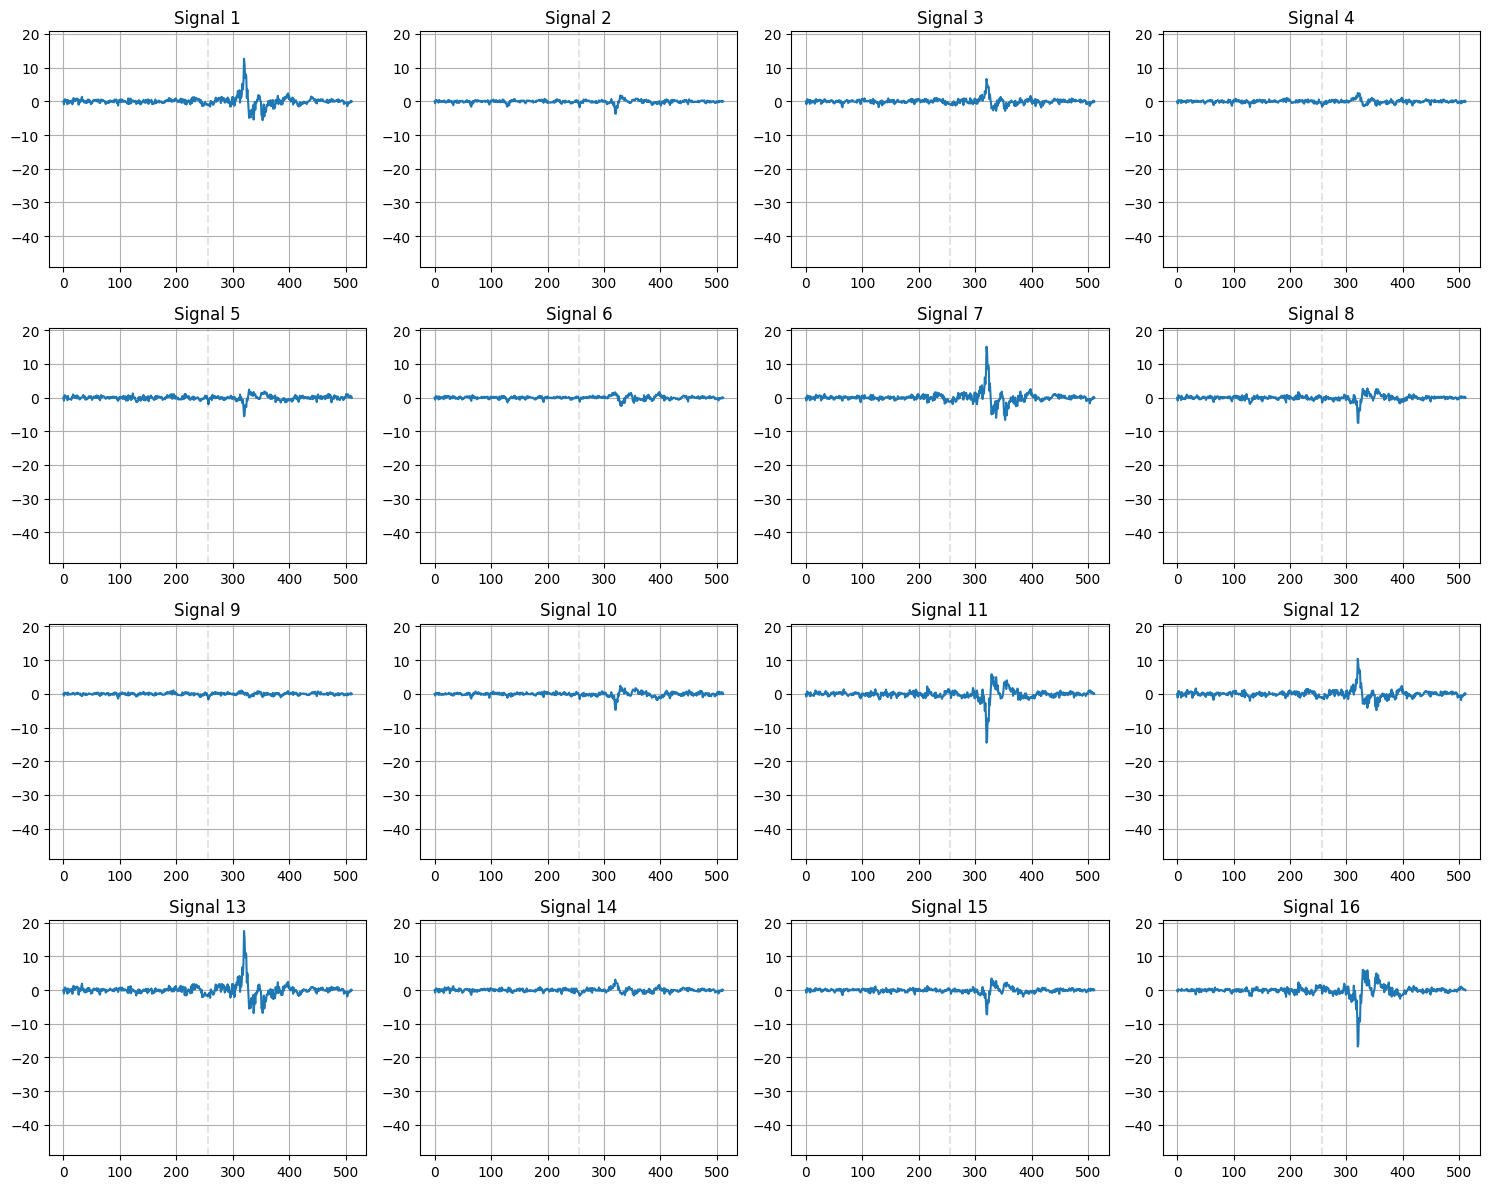

[27/32][0/56]	Loss_D: 0.9857	Loss_G: 8.4015	D(x): 0.1879	D(G(z)): 0.8396 / 0.8656
[27/32][50/56]	Loss_D: 0.6348	Loss_G: 1.5449	D(x): 0.1504	D(G(z)): 0.7106 / 0.6984


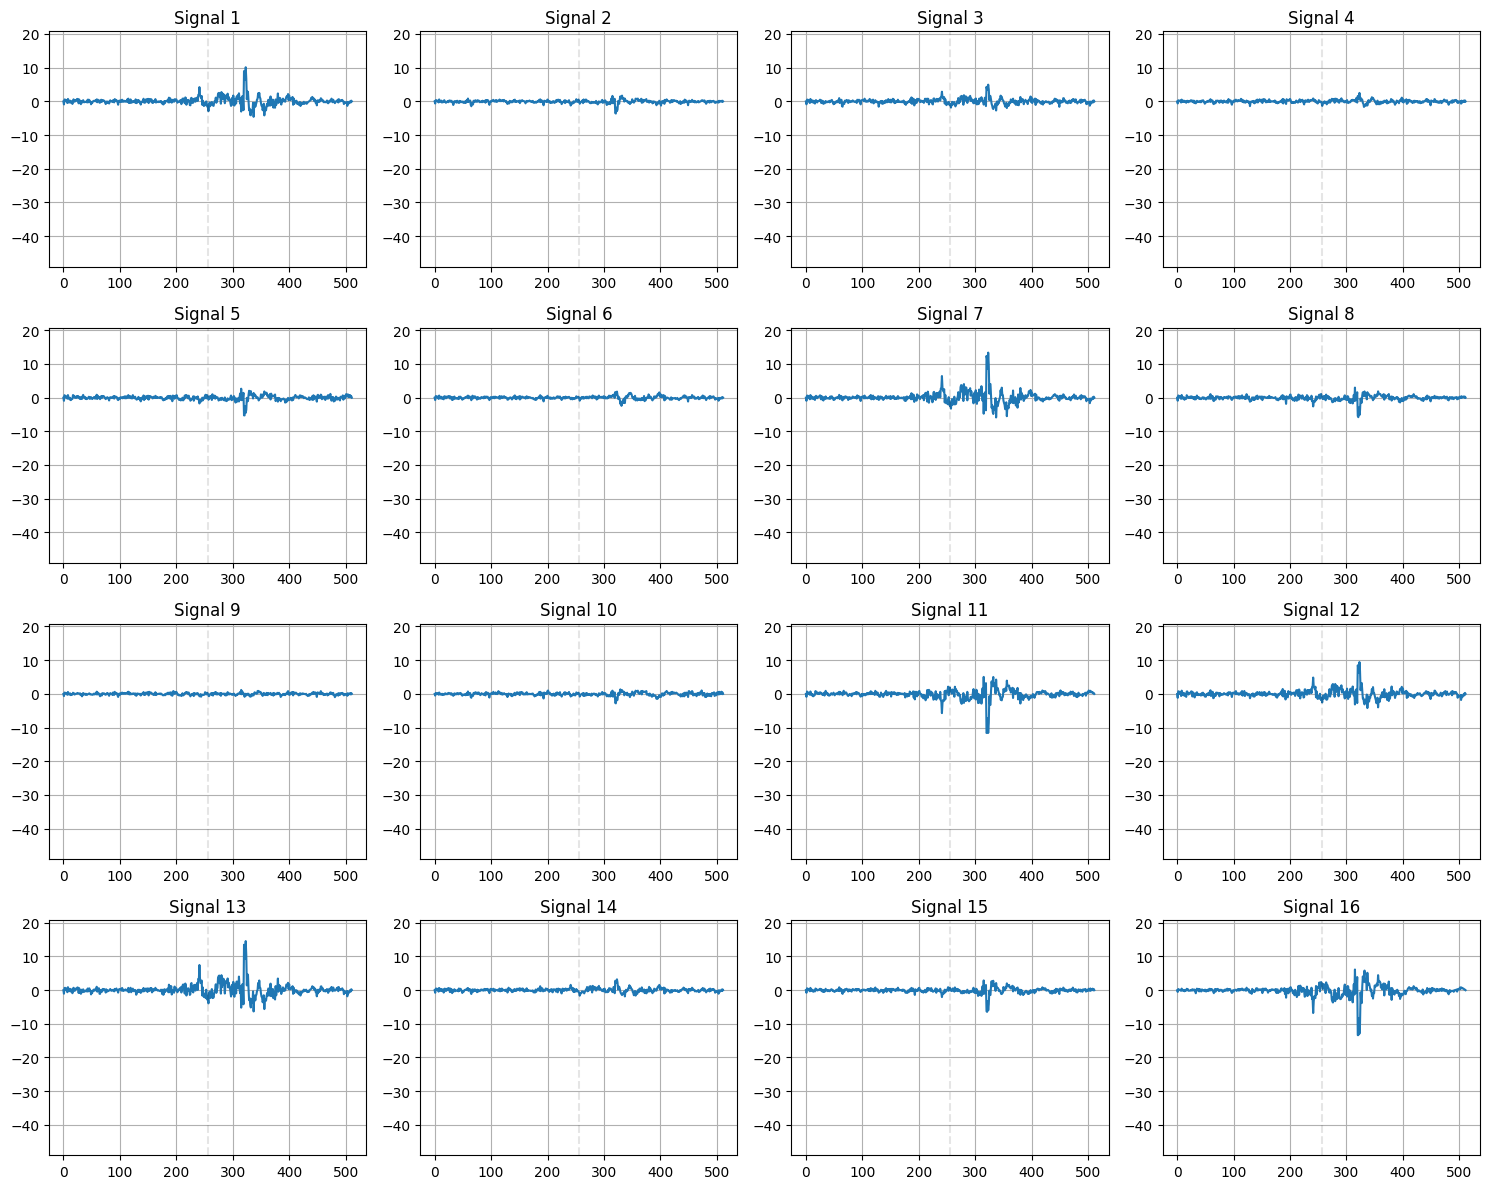

[28/32][0/56]	Loss_D: 0.7093	Loss_G: 2.0318	D(x): 0.0626	D(G(z)): 0.6875 / 0.7697
[28/32][50/56]	Loss_D: 0.9449	Loss_G: 1.6274	D(x): 0.2409	D(G(z)): 0.8368 / 0.7251


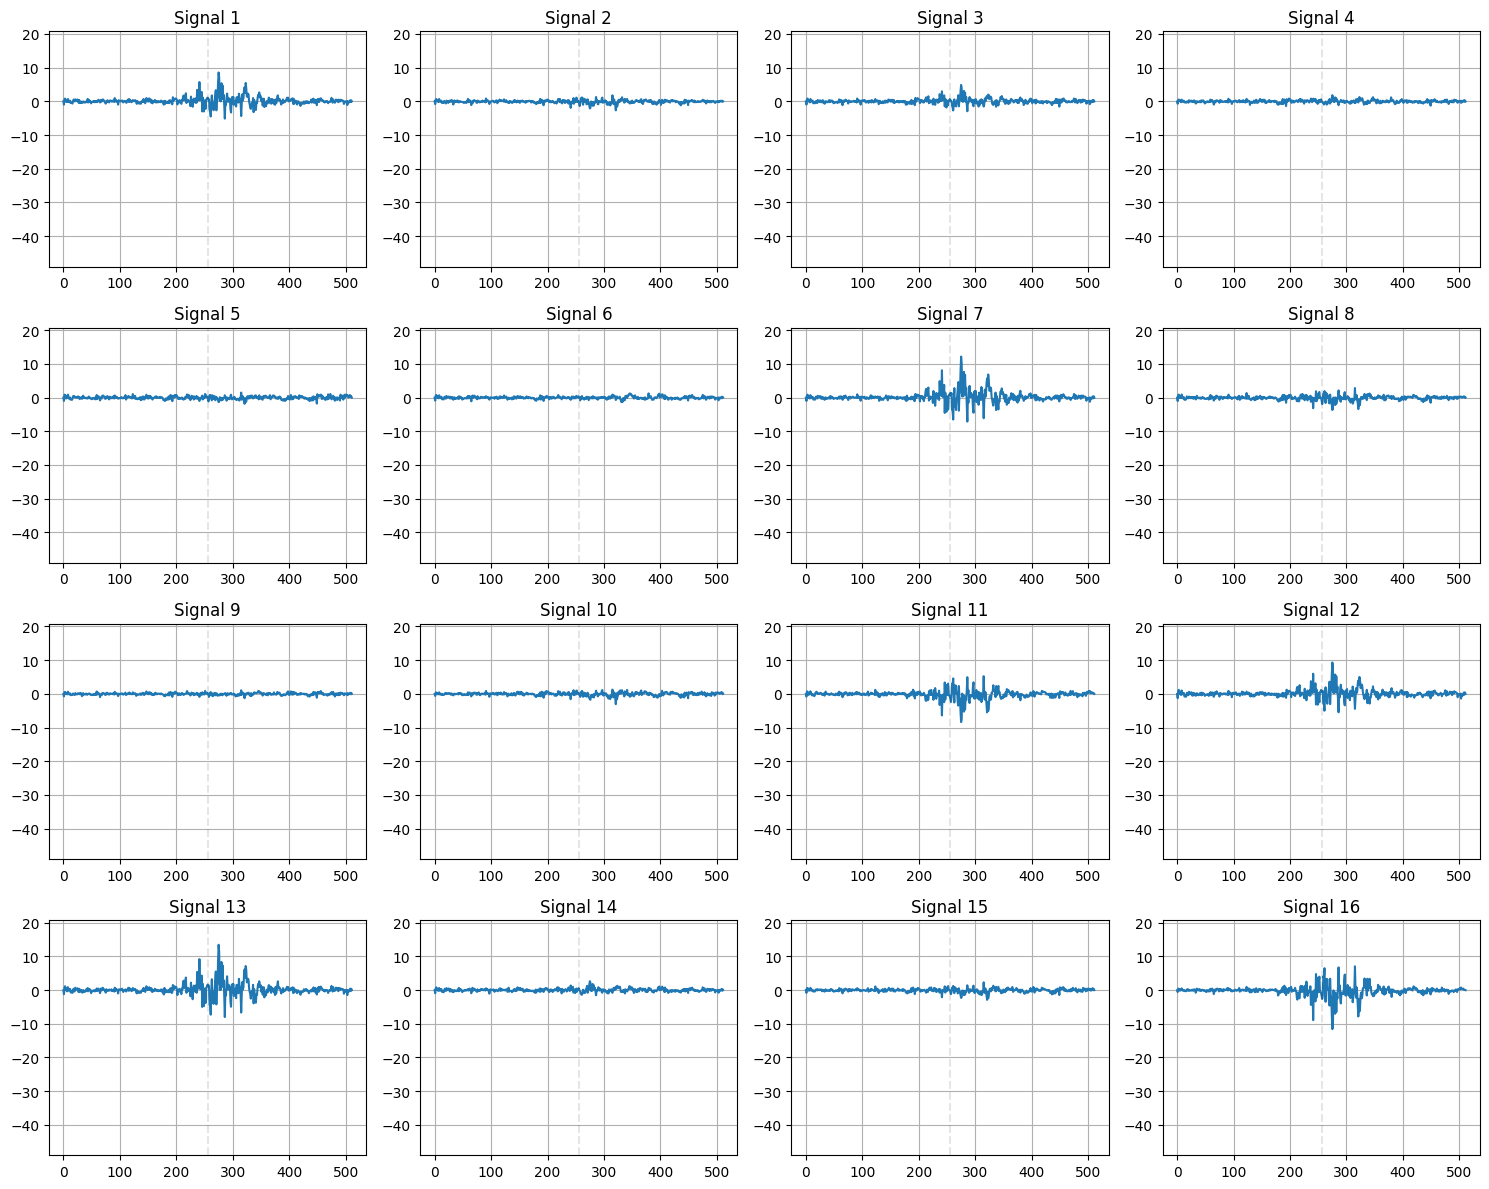

[29/32][0/56]	Loss_D: 0.6606	Loss_G: 2.3018	D(x): 0.0992	D(G(z)): 0.8352 / 0.8265
[29/32][50/56]	Loss_D: 1.0147	Loss_G: 1.5862	D(x): 0.1410	D(G(z)): 0.7675 / 0.7457


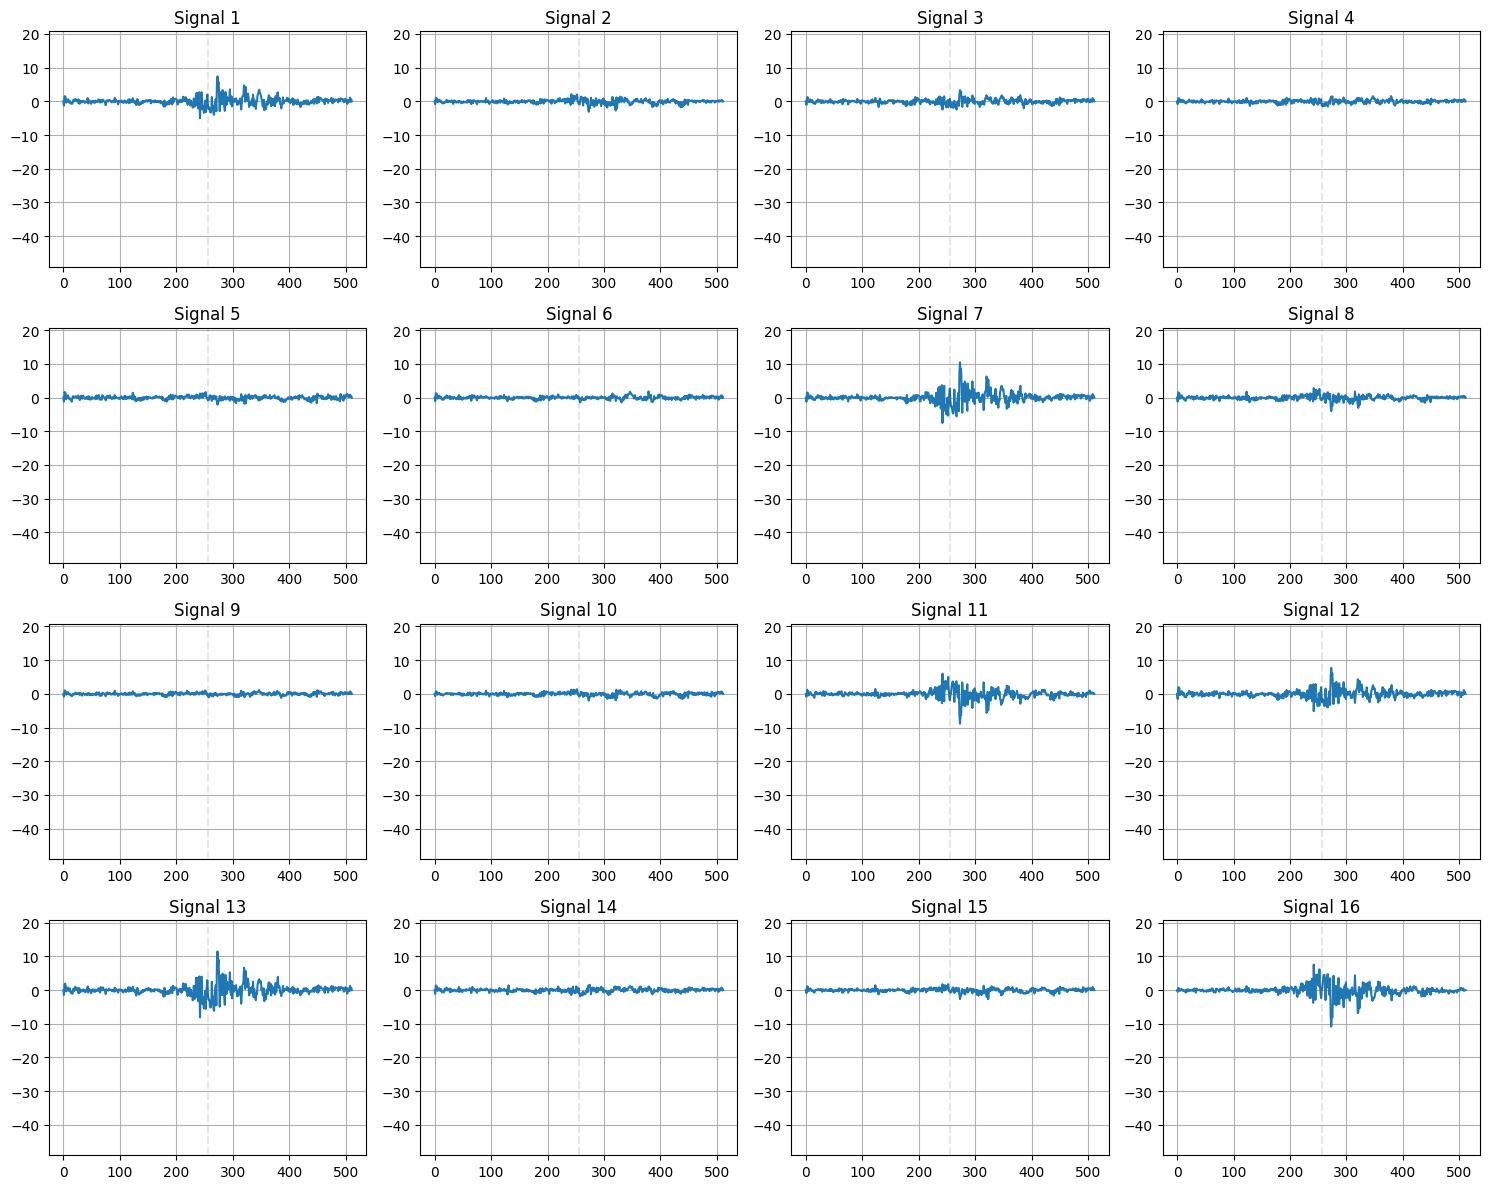

[30/32][0/56]	Loss_D: 0.6459	Loss_G: 1.2430	D(x): 0.2036	D(G(z)): 0.8065 / 0.6425
[30/32][50/56]	Loss_D: 0.9176	Loss_G: 2.1525	D(x): 0.1115	D(G(z)): 0.7912 / 0.8217


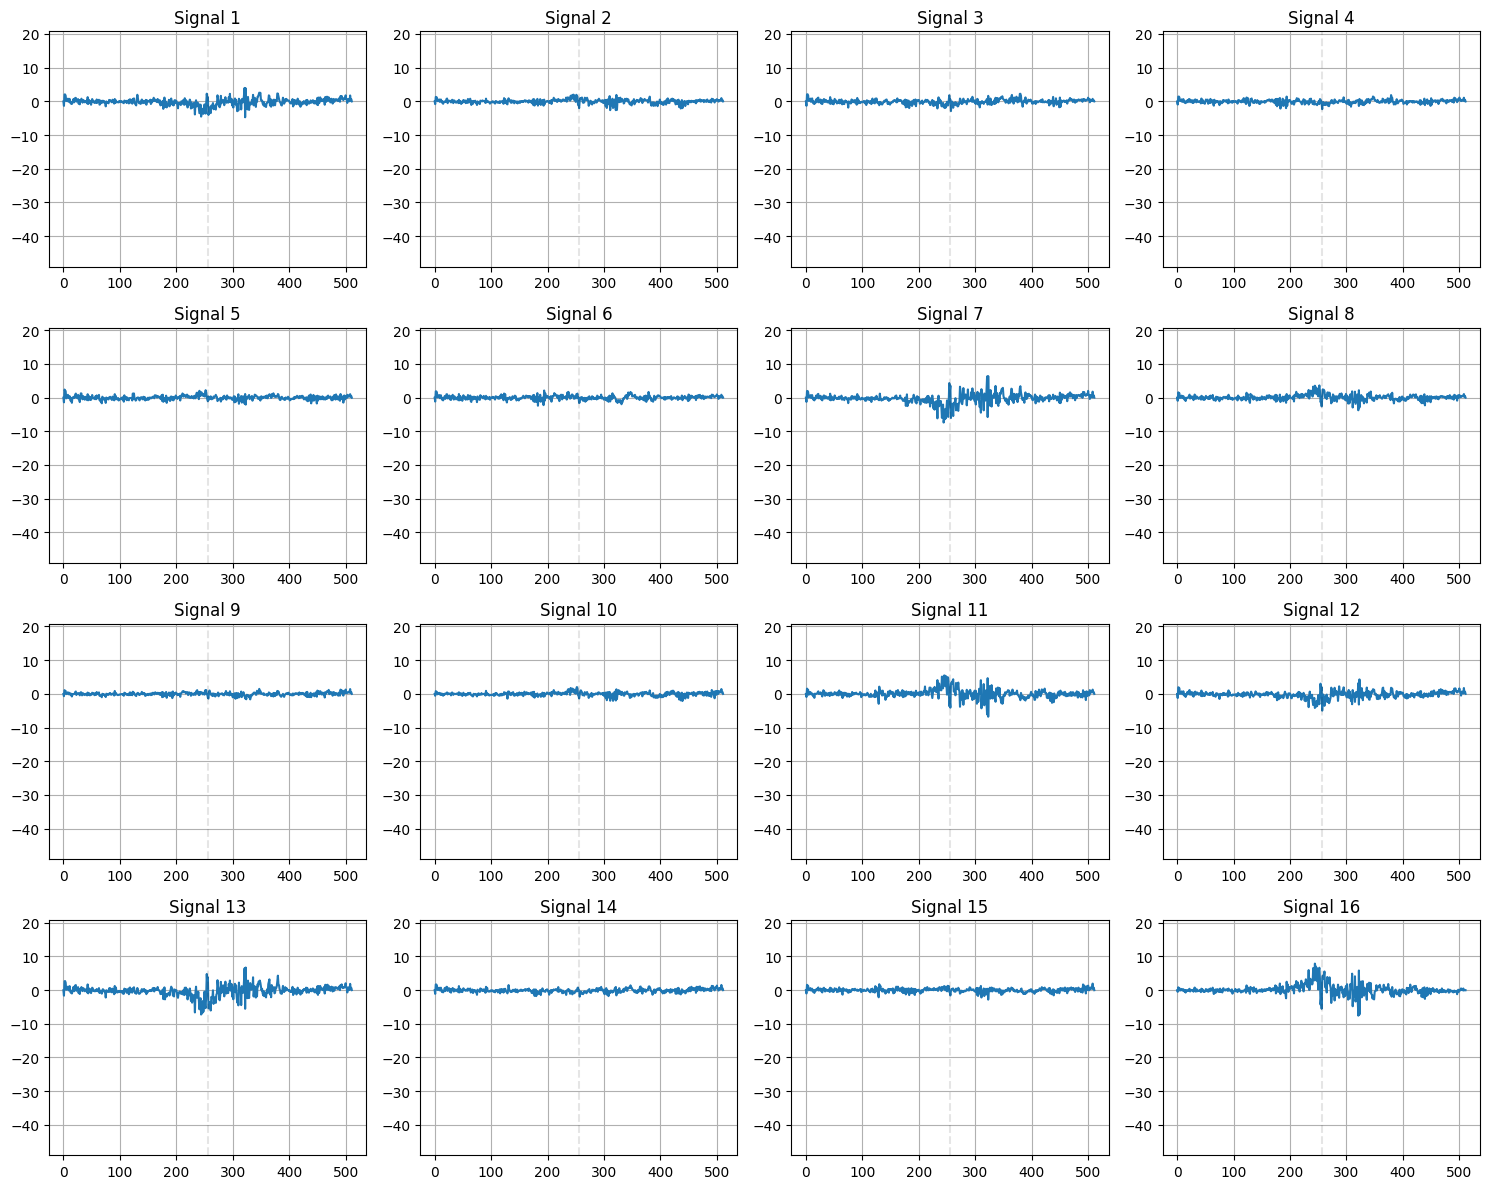

[31/32][0/56]	Loss_D: 0.3735	Loss_G: 1.6627	D(x): 0.1480	D(G(z)): 0.8894 / 0.7198
[31/32][50/56]	Loss_D: 0.6131	Loss_G: 1.9461	D(x): 0.1733	D(G(z)): 0.8070 / 0.7741


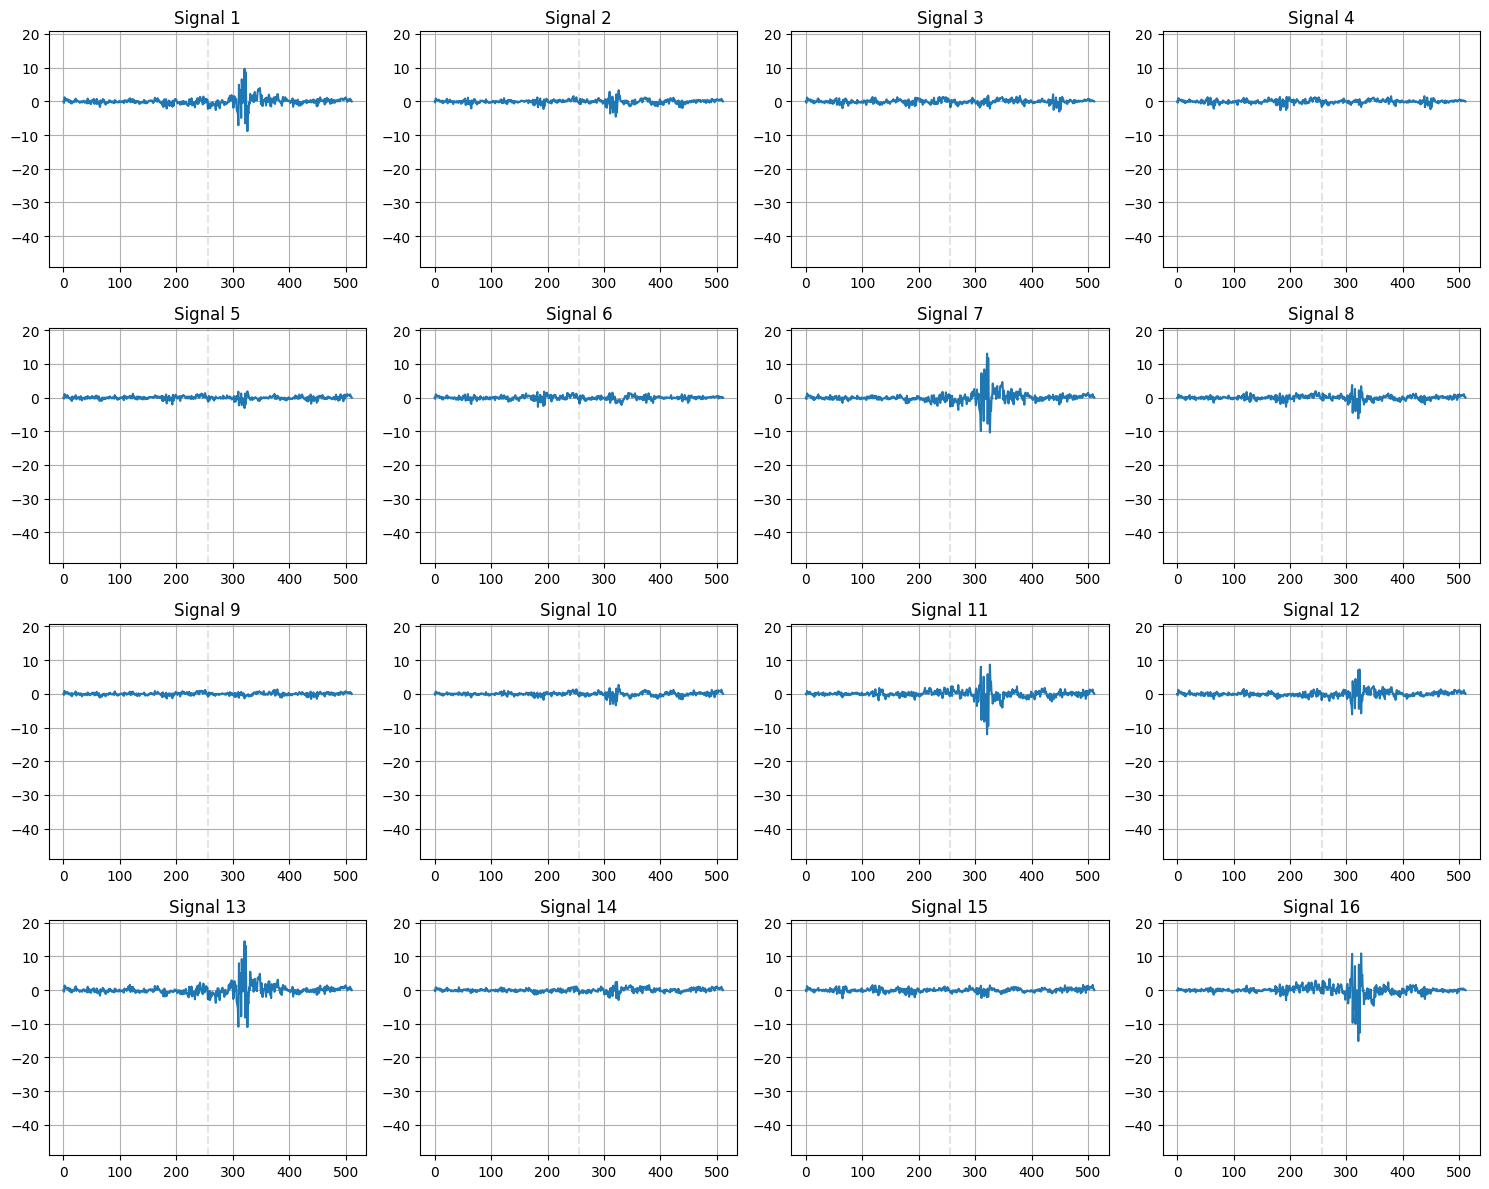

In [564]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data.to(device)
        # print(real_gpu.shape)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device)
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 
    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            ax.plot(x, y)

            ax.axvline(x=256, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % epoch)
        plt.show()

    signal_list.append(fake_signals)

### Gradients

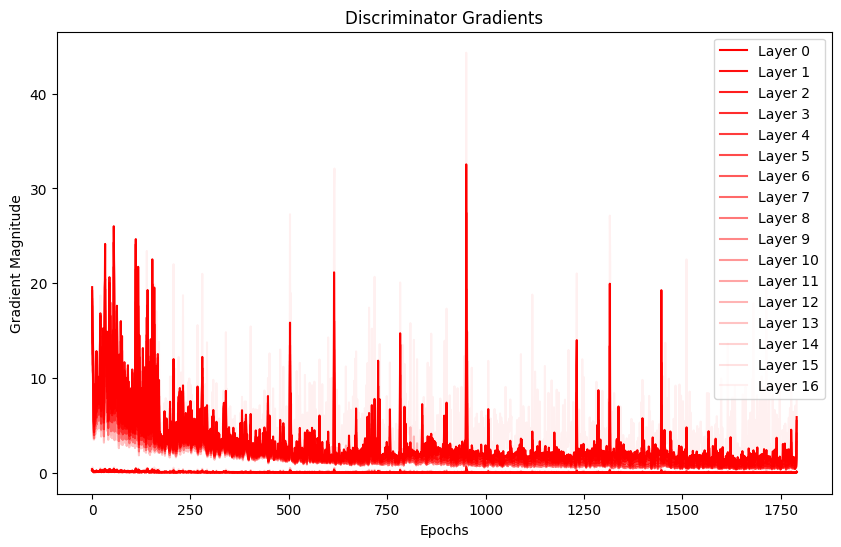

In [565]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

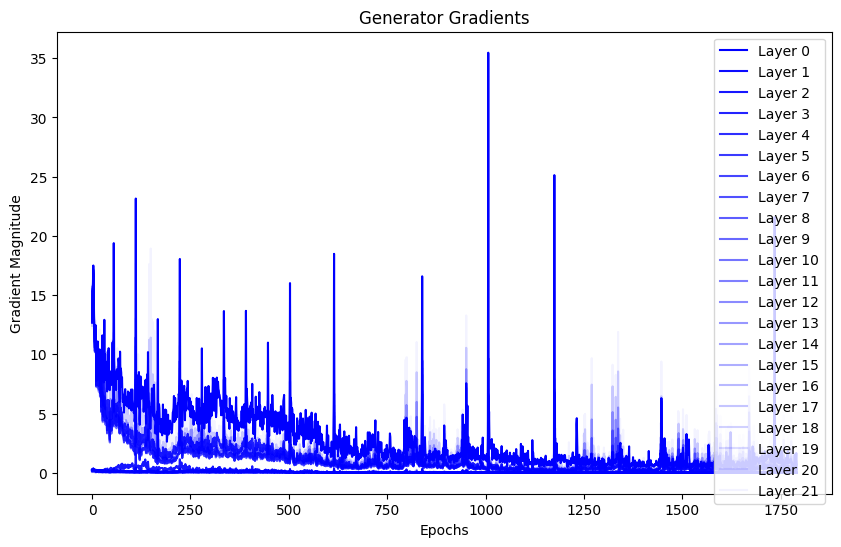

In [566]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

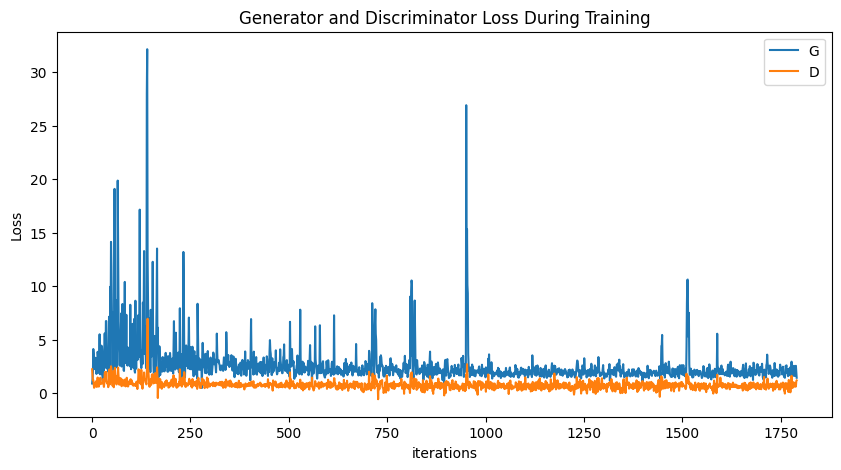

In [567]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 512])


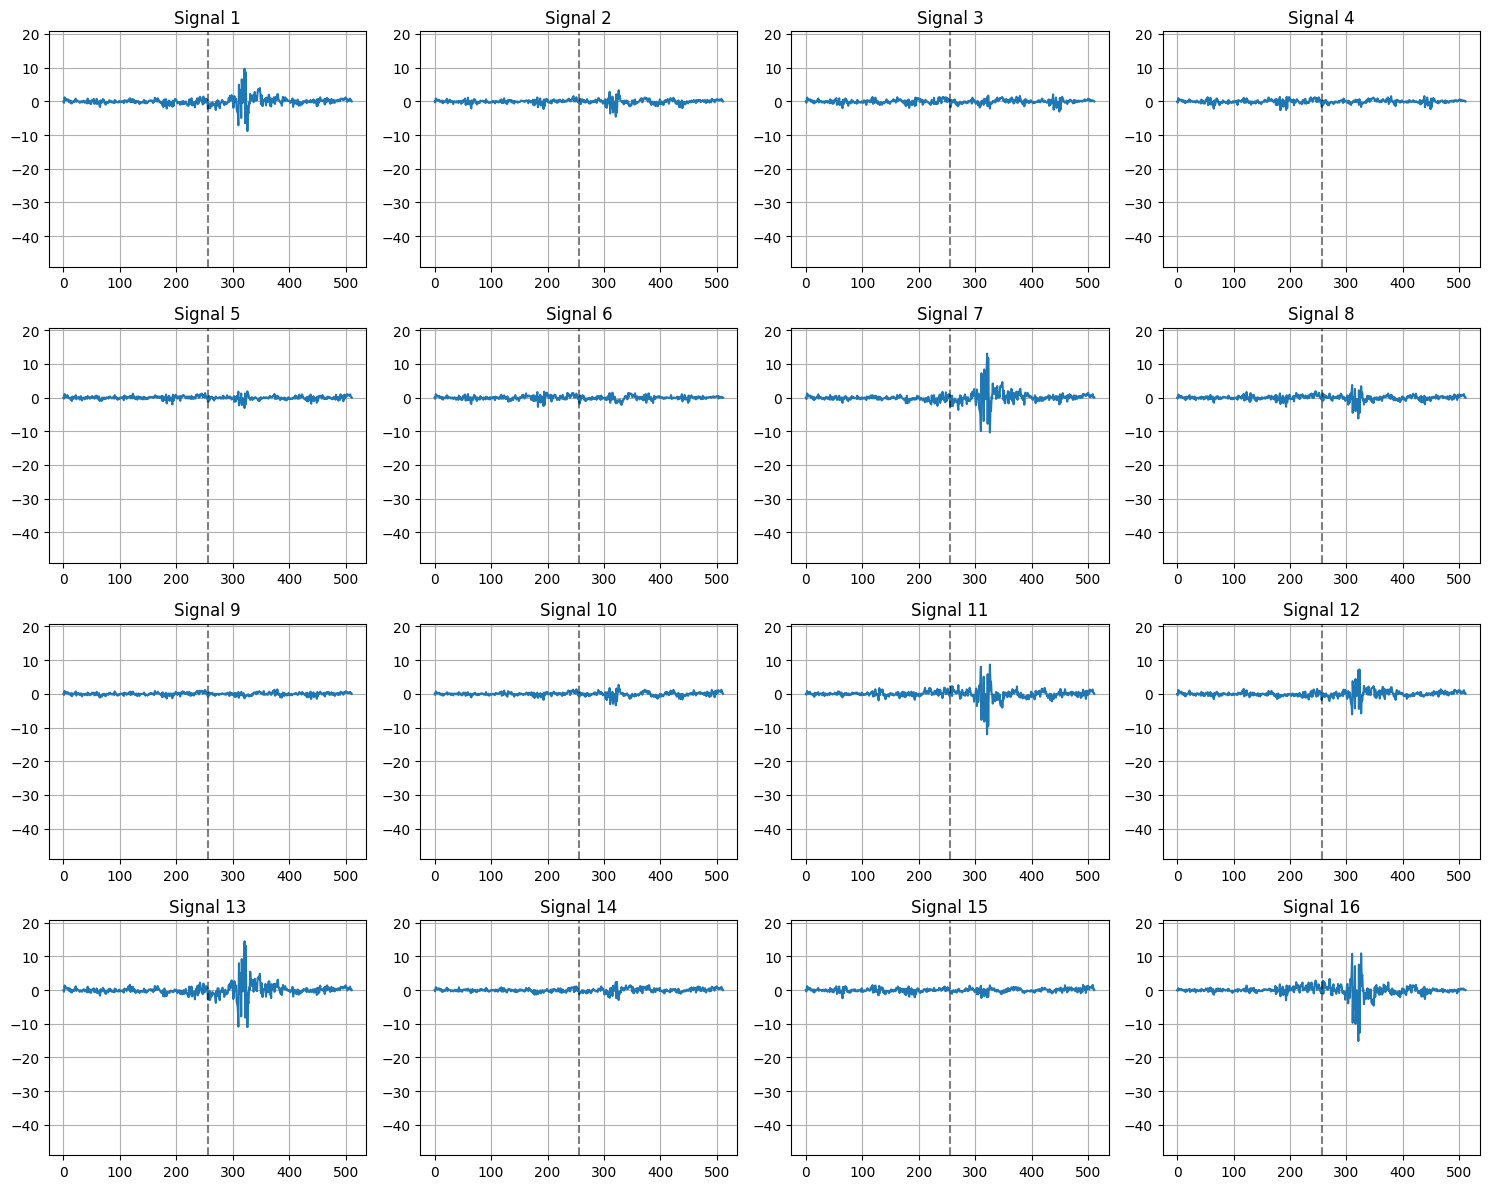

In [568]:
batch = signal_list[31]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [569]:
# # Path to the folder containing PNG images
# image_folder = '../data/gw-dcgans-images'

# # Get a list of image filenames in the folder
# image_filenames = sorted([filename for filename in os.listdir(image_folder) if filename.endswith('.png')])

# # Load images and create an animation
# def update(frame):
#     img_path = os.path.join(image_folder, image_filenames[frame])
#     img = Image.open(img_path)
    
#     # Clear the previous plot
#     plt.clf()
    
#     # Display the image without cropping and centered
#     plt.imshow(img, aspect='auto')
#     plt.axis('off')

# fig = plt.figure(figsize=(8, 8))

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(image_filenames), interval=1000, repeat_delay=1000)

# # Display the animation as HTML (for Jupyter Notebook) or save it to a file
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# Save the animation as an .mp4 video
# output_filename = '../data/gw-dcgans-mp4/signals.mp4'
# ani.save(output_filename, writer='ffmpeg', codec='libx264', fps=8, dpi=100, bitrate=1800)

# print(f'Animation saved as {output_filename}')

In [570]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)
